<a href="https://colab.research.google.com/github/OrionXV/Volve-Well-Log-Prediction/blob/main/notebooks/GANaugment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Augmentation

Predictors used:

* Decsion Tree
* Gradient Booster
* Neural Network
* LSTM


In [6]:
!pip install lasio
!pip install md_toc
!pip install tensorflow
!pip install tensorflow-addons
!pip install smogn

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

from sklearn.svm import OneClassSVM

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam

from keras import layers
from keras import models


import tensorflow as tf
from tqdm import tqdm

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Fetching Data

In [9]:
!git clone https://github.com/OrionXV/Volve-Well-Log-Prediction.git

Cloning into 'Volve-Well-Log-Prediction'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 130 (delta 53), reused 9 (delta 3), pack-reused 0
Receiving objects: 100% (130/130), 62.25 MiB | 16.15 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [10]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"/content/Volve-Well-Log-Prediction/well_logs", "*.LAS")))

# Create a list for loop processing
log_list = [0] * len(paths)

# Parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

,DEPTH,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,DTS,...,PEF,RACEHM,RACELM,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT
0,188.5,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,188.6,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,188.7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188.8,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.9,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepareing Data

In [11]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):

  # Clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) &
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # Select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]

  # Select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# check for NaN
log1.head()

,DEPTH,NPHI,RHOB,GR,RT,PEF,CALI,DT
24115,2600.0,0.371,2.356,82.748,1.323,7.126,8.648,104.605
24116,2600.1,0.341,2.338,79.399,1.196,6.654,8.578,103.827
24117,2600.2,0.308,2.315,74.248,1.171,6.105,8.578,102.740
24118,2600.3,0.283,2.291,68.542,1.142,5.613,8.547,100.943
24119,2600.4,0.272,2.269,60.314,1.107,5.281,8.523,98.473


In [12]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# Assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # Train data, assign names
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # Test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# Concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# Add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# Pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# Train dataframe with logs 1,3,4 vertically stacked
train.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
24115,0.371,2.356,82.748,1.323,7.126,8.648,104.605,15_9-F-11A,2600.0
24116,0.341,2.338,79.399,1.196,6.654,8.578,103.827,15_9-F-11A,2600.1
24117,0.308,2.315,74.248,1.171,6.105,8.578,102.740,15_9-F-11A,2600.2
24118,0.283,2.291,68.542,1.142,5.613,8.547,100.943,15_9-F-11A,2600.3
24119,0.272,2.269,60.314,1.107,5.281,8.523,98.473,15_9-F-11A,2600.4


In [13]:
colnames = train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

## Data Transformation and Normalization

In [14]:
# Log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.13065,-0.631876,0.031083,0.450019,1.58838,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.75808,-0.81989,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.189869,-1.367969,0.837247,-0.816586,-1.441155,-2.286222,1.367432,15_9-F-11A,2600.4


## Outlier Removal

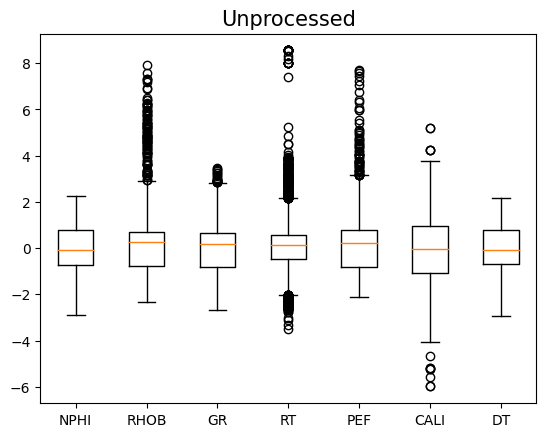

n samples unprocessed: 24403


In [15]:
# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_fonly_names = train_fonly.columns

# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

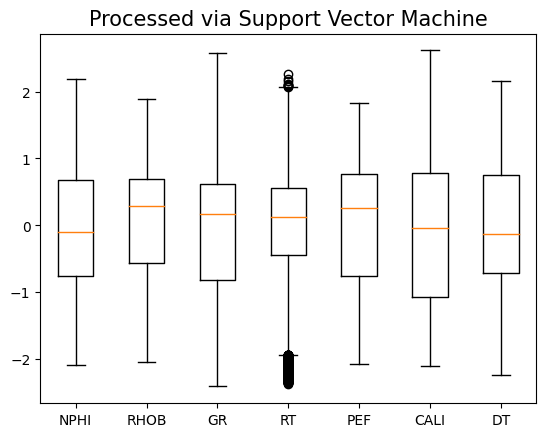

Remaining samples: 21964


In [16]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Processed via Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

In [17]:
feature_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target_name = 'DT'


## Train and Validation Prep

In [18]:
# Select columns for features (X) and target (y)
X_train = train_svm[feature_names].values.astype('float32')
y_train = train_svm[target_name].values.reshape(-1, 1).astype('float32')

# Define the validation data
train_trans_copy = train_trans.copy()

train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_val = []
y_val = []

for i in range(len(train_well_names)):
    # Split the df by log name
    val = train_trans_copy.loc[train_trans_copy['WELL'] == train_well_names[i]].copy()

    # Drop name column
    val.drop(['WELL'], axis=1, inplace=True)

    # Define X_val (feature) and y_val (target) as NumPy arrays
    X_val_ = val[feature_names].values.astype('float32')
    y_val_ = val[target_name].values.reshape(-1, 1).astype('float32')

    X_val.append(X_val_)
    y_val.append(y_val_)

# Save into separate NumPy arrays
X_val1, X_val3, X_val4 = X_val
y_val1, y_val3, y_val4 = y_val

In [19]:
X_train = X_train.astype('float32')

# Cast y_train to float32
y_train = y_train.astype('float32')

# Cast X_val1, X_val3, X_val4 to float32
X_val1 = X_val1.astype('float32')
X_val3 = X_val3.astype('float32')
X_val4 = X_val4.astype('float32')

# Cast y_val1, y_val3, y_val4 to float32
y_val1 = y_val1.astype('float32')
y_val3 = y_val3.astype('float32')
y_val4 = y_val4.astype('float32')

# Data Augmentation

In [20]:
# Select columns for features (X) and target (y)
train_total = pd.merge(train_svm, train_trans, on = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT'], how='left')
train_gen = train_svm.copy()

In [21]:
train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

df_gen1 = train_total[train_total['WELL'] == '15_9-F-11A'].copy()
df_gen3 = train_total[train_total['WELL'] == '15_9-F-1A'].copy()
df_gen4 = train_total[train_total['WELL'] == '15_9-F-1B'].copy()

In [22]:
# # Fit and transform the 'DEPTH' column for df_gen1
# df_gen1['DEPTH'] = scaler.fit_transform(df_gen1[['DEPTH']])

# # Fit and transform the 'DEPTH' column for df_gen3
# df_gen3['DEPTH'] = scaler.fit_transform(df_gen3[['DEPTH']])

# # Fit and transform the 'DEPTH' column for df_gen4
# df_gen4['DEPTH'] = scaler.fit_transform(df_gen4[['DEPTH']])

In [23]:
df_gen1.drop(columns = 'WELL').astype('float32').describe()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,DEPTH
count,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000
mean,-0.112095,-0.003497,-0.274721,0.056440,0.292885,0.118036,-0.094888,3153.243408
std,0.992792,0.944150,0.921068,0.916372,0.998347,0.859239,1.046198,316.025391
min,-2.063082,-2.048020,-2.410065,-2.362914,-1.802307,-2.108308,-2.230961,2600.000000
25%,-0.881575,-0.800520,-0.988074,-0.233863,-0.365790,-0.046527,-0.872950,2888.974976
50%,-0.276245,0.320521,-0.268374,0.237194,0.713391,-0.046527,-0.341816,3152.949951
75%,0.719418,0.724360,0.373959,0.662223,1.113527,0.964887,0.827411,3420.825012
max,2.159336,1.725366,2.386178,2.267929,1.826932,2.615517,2.152846,3719.600098


In [39]:
# Define the GAN model architecture
def build_generator(latent_dim, num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(256, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(256, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(num_features, activation='linear'))  # Output layer
    return model

def build_discriminator(num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_shape=(num_features,), activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(256, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(256, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer
    return model



In [40]:
generator_loss_fn =  tf.keras.losses.BinaryFocalCrossentropy()
discriminator_loss =  tf.keras.losses.BinaryFocalCrossentropy()


In [41]:
def train_gan(generator, discriminator, epochs, batch_size, data_frame, generator_optimizer, discriminator_optimizer):
    data_frame = data_frame

    # Determine the number of batches
    num_samples = len(data_frame)
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        avg_gen_loss = 0
        avg_disc_loss = 0
        with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:

            for batch in range(num_batches):

                # Get real data for the current batch
                batch_start = batch * batch_size
                batch_end = (batch + 1) * batch_size
                real_data = data_frame.iloc[batch_start:batch_end]
                real_data = real_data.values.astype('float32')

                # Sample random noise for generator input
                noise = np.random.uniform(-1, 1, size=(len(real_data), latent_dim))

                # Generate synthetic data
                generated_data = generator.predict(noise,  verbose=0)

                # Combine real and generated data
                x_combined = np.concatenate([real_data, generated_data])

                # Labels for real and generated data
                y_real = np.ones((batch_size, 1))
                y_generated = np.zeros((batch_size, 1))
                y_combined = np.concatenate([y_real, y_generated])

                # Train discriminator
                with tf.GradientTape() as disc_tape:
                    # Forward pass: compute logits for real and fake samples
                    real_logits = discriminator(real_data, training=True)
                    fake_logits = discriminator(generated_data, training=True)

                    # Compute discriminator loss
                    real_labels = tf.ones_like(real_logits)
                    fake_labels = tf.zeros_like(fake_logits)
                    discriminator_loss_real = discriminator_loss(real_labels, real_logits)
                    discriminator_loss_fake = discriminator_loss(fake_labels, fake_logits)
                    discriminator_loss_total = (discriminator_loss_real + discriminator_loss_fake)

                # Compute gradients of discriminator loss with respect to discriminator trainable variables
                gradients_of_discriminator = disc_tape.gradient(discriminator_loss_total, discriminator.trainable_variables)

                # Update discriminator weights using optimizer
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

                with tf.GradientTape() as gen_tape:
                    # Generate fake samples using the generator
                    fake_samples = generator(noise, training=True)

                    # Compute generator loss
                    generator_loss = generator_loss_fn(real_labels, discriminator(fake_samples, training=True))

                # Compute gradients of generator loss with respect to generator trainable variables
                gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)

                # Update generator weights using optimizer
                generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

                avg_disc_loss += discriminator_loss_total
                avg_gen_loss +=  generator_loss

                pbar.update(1)

            # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {avg_disc_loss/num_batches}, Generator Loss: {avg_gen_loss/num_batches}")


In [42]:
# Generate synthetic data for certain depths
def generate_synthetic_data(generator, num_samples):
    noise = np.random.uniform(-1, 1, size=(num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data


In [44]:
# Train the GAN
# Define GAN components

latent_dim = 256

num_features = len(train_gen.columns)

generator_1 = build_generator(latent_dim, num_features)
discriminator_1 = build_discriminator(num_features)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

epochs = 128
batch_size = 4096
num_batches = len(train_gen) // batch_size
train_gan(generator_1, discriminator_1, epochs, batch_size, train_gen, generator_optimizer, discriminator_optimizer)

Epoch 1/128: 100%|██████████| 5/5 [00:09<00:00,  1.88s/batch]


Epoch 1/128, Discriminator Loss: 0.9324852824211121, Generator Loss: 0.46284180879592896


Epoch 2/128: 100%|██████████| 5/5 [00:02<00:00,  1.69batch/s]


Epoch 2/128, Discriminator Loss: 0.8878481984138489, Generator Loss: 0.41128605604171753


Epoch 3/128: 100%|██████████| 5/5 [00:02<00:00,  1.72batch/s]


Epoch 3/128, Discriminator Loss: 0.8422737121582031, Generator Loss: 0.37386977672576904


Epoch 4/128: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s]


Epoch 4/128, Discriminator Loss: 0.7887141704559326, Generator Loss: 0.34854406118392944


Epoch 5/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 5/128, Discriminator Loss: 0.7409358024597168, Generator Loss: 0.32853594422340393


Epoch 6/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 6/128, Discriminator Loss: 0.6923205852508545, Generator Loss: 0.31206220388412476


Epoch 7/128: 100%|██████████| 5/5 [00:02<00:00,  1.79batch/s]


Epoch 7/128, Discriminator Loss: 0.6560068130493164, Generator Loss: 0.301382839679718


Epoch 8/128: 100%|██████████| 5/5 [00:03<00:00,  1.40batch/s]


Epoch 8/128, Discriminator Loss: 0.6291695237159729, Generator Loss: 0.2910246253013611


Epoch 9/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 9/128, Discriminator Loss: 0.6127935647964478, Generator Loss: 0.27968284487724304


Epoch 10/128: 100%|██████████| 5/5 [00:02<00:00,  1.67batch/s]


Epoch 10/128, Discriminator Loss: 0.5973924398422241, Generator Loss: 0.2733011245727539


Epoch 11/128: 100%|██████████| 5/5 [00:03<00:00,  1.63batch/s]


Epoch 11/128, Discriminator Loss: 0.5828112959861755, Generator Loss: 0.26775628328323364


Epoch 12/128: 100%|██████████| 5/5 [00:03<00:00,  1.32batch/s]


Epoch 12/128, Discriminator Loss: 0.5705097913742065, Generator Loss: 0.26376065611839294


Epoch 13/128: 100%|██████████| 5/5 [00:02<00:00,  1.69batch/s]


Epoch 13/128, Discriminator Loss: 0.5597176551818848, Generator Loss: 0.2591439485549927


Epoch 14/128: 100%|██████████| 5/5 [00:02<00:00,  1.78batch/s]


Epoch 14/128, Discriminator Loss: 0.5497391819953918, Generator Loss: 0.255485475063324


Epoch 15/128: 100%|██████████| 5/5 [00:03<00:00,  1.60batch/s]


Epoch 15/128, Discriminator Loss: 0.5405691266059875, Generator Loss: 0.24960553646087646


Epoch 16/128: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s]


Epoch 16/128, Discriminator Loss: 0.5307997465133667, Generator Loss: 0.24851436913013458


Epoch 17/128: 100%|██████████| 5/5 [00:02<00:00,  1.78batch/s]


Epoch 17/128, Discriminator Loss: 0.5222552418708801, Generator Loss: 0.2451159954071045


Epoch 18/128: 100%|██████████| 5/5 [00:02<00:00,  1.80batch/s]


Epoch 18/128, Discriminator Loss: 0.5136743783950806, Generator Loss: 0.24052481353282928


Epoch 19/128: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s]


Epoch 19/128, Discriminator Loss: 0.507524847984314, Generator Loss: 0.23835687339305878


Epoch 20/128: 100%|██████████| 5/5 [00:02<00:00,  1.72batch/s]


Epoch 20/128, Discriminator Loss: 0.502135157585144, Generator Loss: 0.23509708046913147


Epoch 21/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 21/128, Discriminator Loss: 0.4948253035545349, Generator Loss: 0.2309967279434204


Epoch 22/128: 100%|██████████| 5/5 [00:02<00:00,  1.74batch/s]


Epoch 22/128, Discriminator Loss: 0.4904082417488098, Generator Loss: 0.22965335845947266


Epoch 23/128: 100%|██████████| 5/5 [00:04<00:00,  1.00batch/s]


Epoch 23/128, Discriminator Loss: 0.4862911105155945, Generator Loss: 0.22758495807647705


Epoch 24/128: 100%|██████████| 5/5 [00:02<00:00,  1.84batch/s]


Epoch 24/128, Discriminator Loss: 0.4807540476322174, Generator Loss: 0.2242446392774582


Epoch 25/128: 100%|██████████| 5/5 [00:02<00:00,  1.79batch/s]


Epoch 25/128, Discriminator Loss: 0.47680434584617615, Generator Loss: 0.22335633635520935


Epoch 26/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 26/128, Discriminator Loss: 0.4728010296821594, Generator Loss: 0.21967723965644836


Epoch 27/128: 100%|██████████| 5/5 [00:03<00:00,  1.46batch/s]


Epoch 27/128, Discriminator Loss: 0.4681980609893799, Generator Loss: 0.21791569888591766


Epoch 28/128: 100%|██████████| 5/5 [00:02<00:00,  1.74batch/s]


Epoch 28/128, Discriminator Loss: 0.46467846632003784, Generator Loss: 0.21617484092712402


Epoch 29/128: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]


Epoch 29/128, Discriminator Loss: 0.46122437715530396, Generator Loss: 0.2152864634990692


Epoch 30/128: 100%|██████████| 5/5 [00:03<00:00,  1.53batch/s]


Epoch 30/128, Discriminator Loss: 0.4574570059776306, Generator Loss: 0.2132311314344406


Epoch 31/128: 100%|██████████| 5/5 [00:04<00:00,  1.20batch/s]


Epoch 31/128, Discriminator Loss: 0.4542093276977539, Generator Loss: 0.2117249071598053


Epoch 32/128: 100%|██████████| 5/5 [00:02<00:00,  1.78batch/s]


Epoch 32/128, Discriminator Loss: 0.451193243265152, Generator Loss: 0.21051840484142303


Epoch 33/128: 100%|██████████| 5/5 [00:02<00:00,  1.75batch/s]


Epoch 33/128, Discriminator Loss: 0.44885167479515076, Generator Loss: 0.20971493422985077


Epoch 34/128: 100%|██████████| 5/5 [00:02<00:00,  1.82batch/s]


Epoch 34/128, Discriminator Loss: 0.4463486075401306, Generator Loss: 0.20929975807666779


Epoch 35/128: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s]


Epoch 35/128, Discriminator Loss: 0.4429308772087097, Generator Loss: 0.20779237151145935


Epoch 36/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 36/128, Discriminator Loss: 0.4413188099861145, Generator Loss: 0.20648515224456787


Epoch 37/128: 100%|██████████| 5/5 [00:02<00:00,  1.87batch/s]


Epoch 37/128, Discriminator Loss: 0.4387804865837097, Generator Loss: 0.20512127876281738


Epoch 38/128: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]


Epoch 38/128, Discriminator Loss: 0.4369131624698639, Generator Loss: 0.20454733073711395


Epoch 39/128: 100%|██████████| 5/5 [00:03<00:00,  1.36batch/s]


Epoch 39/128, Discriminator Loss: 0.4344480037689209, Generator Loss: 0.20408347249031067


Epoch 40/128: 100%|██████████| 5/5 [00:04<00:00,  1.24batch/s]


Epoch 40/128, Discriminator Loss: 0.4323304295539856, Generator Loss: 0.20282824337482452


Epoch 41/128: 100%|██████████| 5/5 [00:03<00:00,  1.54batch/s]


Epoch 41/128, Discriminator Loss: 0.4303269386291504, Generator Loss: 0.20230408012866974


Epoch 42/128: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s]


Epoch 42/128, Discriminator Loss: 0.4280703663825989, Generator Loss: 0.2010299265384674


Epoch 43/128: 100%|██████████| 5/5 [00:02<00:00,  1.67batch/s]


Epoch 43/128, Discriminator Loss: 0.42681750655174255, Generator Loss: 0.2006211280822754


Epoch 44/128: 100%|██████████| 5/5 [00:02<00:00,  1.68batch/s]


Epoch 44/128, Discriminator Loss: 0.4262998700141907, Generator Loss: 0.20029234886169434


Epoch 45/128: 100%|██████████| 5/5 [00:02<00:00,  1.72batch/s]


Epoch 45/128, Discriminator Loss: 0.423137366771698, Generator Loss: 0.19887033104896545


Epoch 46/128: 100%|██████████| 5/5 [00:03<00:00,  1.36batch/s]


Epoch 46/128, Discriminator Loss: 0.421781450510025, Generator Loss: 0.19866272807121277


Epoch 47/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 47/128, Discriminator Loss: 0.420482873916626, Generator Loss: 0.1981566846370697


Epoch 48/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 48/128, Discriminator Loss: 0.41888228058815, Generator Loss: 0.19726745784282684


Epoch 49/128: 100%|██████████| 5/5 [00:03<00:00,  1.62batch/s]


Epoch 49/128, Discriminator Loss: 0.41701236367225647, Generator Loss: 0.1968880444765091


Epoch 50/128: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s]


Epoch 50/128, Discriminator Loss: 0.415713369846344, Generator Loss: 0.19612884521484375


Epoch 51/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 51/128, Discriminator Loss: 0.41485342383384705, Generator Loss: 0.19590958952903748


Epoch 52/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 52/128, Discriminator Loss: 0.4133980870246887, Generator Loss: 0.1952759325504303


Epoch 53/128: 100%|██████████| 5/5 [00:03<00:00,  1.57batch/s]


Epoch 53/128, Discriminator Loss: 0.41232043504714966, Generator Loss: 0.19536879658699036


Epoch 54/128: 100%|██████████| 5/5 [00:03<00:00,  1.47batch/s]


Epoch 54/128, Discriminator Loss: 0.41053932905197144, Generator Loss: 0.1943006068468094


Epoch 55/128: 100%|██████████| 5/5 [00:02<00:00,  1.80batch/s]


Epoch 55/128, Discriminator Loss: 0.4097442626953125, Generator Loss: 0.19369809329509735


Epoch 56/128: 100%|██████████| 5/5 [00:02<00:00,  1.83batch/s]


Epoch 56/128, Discriminator Loss: 0.40804821252822876, Generator Loss: 0.19265474379062653


Epoch 57/128: 100%|██████████| 5/5 [00:03<00:00,  1.48batch/s]


Epoch 57/128, Discriminator Loss: 0.4070274233818054, Generator Loss: 0.1928153783082962


Epoch 58/128: 100%|██████████| 5/5 [00:03<00:00,  1.53batch/s]


Epoch 58/128, Discriminator Loss: 0.40606993436813354, Generator Loss: 0.19218650460243225


Epoch 59/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 59/128, Discriminator Loss: 0.4053688943386078, Generator Loss: 0.19248035550117493


Epoch 60/128: 100%|██████████| 5/5 [00:02<00:00,  1.74batch/s]


Epoch 60/128, Discriminator Loss: 0.4042387902736664, Generator Loss: 0.1918996274471283


Epoch 61/128: 100%|██████████| 5/5 [00:04<00:00,  1.10batch/s]


Epoch 61/128, Discriminator Loss: 0.402961790561676, Generator Loss: 0.19079506397247314


Epoch 62/128: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]


Epoch 62/128, Discriminator Loss: 0.40239185094833374, Generator Loss: 0.19121868908405304


Epoch 63/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 63/128, Discriminator Loss: 0.4016694128513336, Generator Loss: 0.19122011959552765


Epoch 64/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 64/128, Discriminator Loss: 0.40081787109375, Generator Loss: 0.19035716354846954


Epoch 65/128: 100%|██████████| 5/5 [00:04<00:00,  1.10batch/s]


Epoch 65/128, Discriminator Loss: 0.39961105585098267, Generator Loss: 0.1900712102651596


Epoch 66/128: 100%|██████████| 5/5 [00:02<00:00,  1.74batch/s]


Epoch 66/128, Discriminator Loss: 0.3990744650363922, Generator Loss: 0.18957002460956573


Epoch 67/128: 100%|██████████| 5/5 [00:02<00:00,  1.74batch/s]


Epoch 67/128, Discriminator Loss: 0.39856013655662537, Generator Loss: 0.18959887325763702


Epoch 68/128: 100%|██████████| 5/5 [00:02<00:00,  1.83batch/s]


Epoch 68/128, Discriminator Loss: 0.39757996797561646, Generator Loss: 0.18911483883857727


Epoch 69/128: 100%|██████████| 5/5 [00:03<00:00,  1.37batch/s]


Epoch 69/128, Discriminator Loss: 0.39693504571914673, Generator Loss: 0.18881604075431824


Epoch 70/128: 100%|██████████| 5/5 [00:02<00:00,  1.82batch/s]


Epoch 70/128, Discriminator Loss: 0.3962472379207611, Generator Loss: 0.1891244351863861


Epoch 71/128: 100%|██████████| 5/5 [00:02<00:00,  1.82batch/s]


Epoch 71/128, Discriminator Loss: 0.39533713459968567, Generator Loss: 0.18850339949131012


Epoch 72/128: 100%|██████████| 5/5 [00:03<00:00,  1.56batch/s]


Epoch 72/128, Discriminator Loss: 0.39515548944473267, Generator Loss: 0.18860962986946106


Epoch 73/128: 100%|██████████| 5/5 [00:03<00:00,  1.47batch/s]


Epoch 73/128, Discriminator Loss: 0.39444535970687866, Generator Loss: 0.18827329576015472


Epoch 74/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 74/128, Discriminator Loss: 0.3931828439235687, Generator Loss: 0.1873466968536377


Epoch 75/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 75/128, Discriminator Loss: 0.3927581012248993, Generator Loss: 0.18750309944152832


Epoch 76/128: 100%|██████████| 5/5 [00:03<00:00,  1.54batch/s]


Epoch 76/128, Discriminator Loss: 0.392376571893692, Generator Loss: 0.1875985711812973


Epoch 77/128: 100%|██████████| 5/5 [00:03<00:00,  1.55batch/s]


Epoch 77/128, Discriminator Loss: 0.3921782374382019, Generator Loss: 0.18776650726795197


Epoch 78/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 78/128, Discriminator Loss: 0.3908037543296814, Generator Loss: 0.18666842579841614


Epoch 79/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 79/128, Discriminator Loss: 0.39009910821914673, Generator Loss: 0.18688254058361053


Epoch 80/128: 100%|██████████| 5/5 [00:03<00:00,  1.66batch/s]


Epoch 80/128, Discriminator Loss: 0.3897583782672882, Generator Loss: 0.18674401938915253


Epoch 81/128: 100%|██████████| 5/5 [00:03<00:00,  1.52batch/s]


Epoch 81/128, Discriminator Loss: 0.3894707262516022, Generator Loss: 0.18677125871181488


Epoch 82/128: 100%|██████████| 5/5 [00:02<00:00,  1.70batch/s]


Epoch 82/128, Discriminator Loss: 0.38852888345718384, Generator Loss: 0.18608883023262024


Epoch 83/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 83/128, Discriminator Loss: 0.38812971115112305, Generator Loss: 0.18615666031837463


Epoch 84/128: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s]


Epoch 84/128, Discriminator Loss: 0.3876766562461853, Generator Loss: 0.1860429346561432


Epoch 85/128: 100%|██████████| 5/5 [00:02<00:00,  1.70batch/s]


Epoch 85/128, Discriminator Loss: 0.38718944787979126, Generator Loss: 0.1859017014503479


Epoch 86/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 86/128, Discriminator Loss: 0.3866064250469208, Generator Loss: 0.1854027807712555


Epoch 87/128: 100%|██████████| 5/5 [00:02<00:00,  1.68batch/s]


Epoch 87/128, Discriminator Loss: 0.38578465580940247, Generator Loss: 0.18532495200634003


Epoch 88/128: 100%|██████████| 5/5 [00:03<00:00,  1.47batch/s]


Epoch 88/128, Discriminator Loss: 0.386126309633255, Generator Loss: 0.18546096980571747


Epoch 89/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 89/128, Discriminator Loss: 0.38522160053253174, Generator Loss: 0.1851661503314972


Epoch 90/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 90/128, Discriminator Loss: 0.3847798705101013, Generator Loss: 0.18514816462993622


Epoch 91/128: 100%|██████████| 5/5 [00:03<00:00,  1.64batch/s]


Epoch 91/128, Discriminator Loss: 0.38409265875816345, Generator Loss: 0.18472588062286377


Epoch 92/128: 100%|██████████| 5/5 [00:04<00:00,  1.22batch/s]


Epoch 92/128, Discriminator Loss: 0.3838142454624176, Generator Loss: 0.1847851276397705


Epoch 93/128: 100%|██████████| 5/5 [00:02<00:00,  1.80batch/s]


Epoch 93/128, Discriminator Loss: 0.38368096947669983, Generator Loss: 0.1844843477010727


Epoch 94/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 94/128, Discriminator Loss: 0.3830487132072449, Generator Loss: 0.18440768122673035


Epoch 95/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 95/128, Discriminator Loss: 0.3829788267612457, Generator Loss: 0.1845645159482956


Epoch 96/128: 100%|██████████| 5/5 [00:03<00:00,  1.41batch/s]


Epoch 96/128, Discriminator Loss: 0.38216301798820496, Generator Loss: 0.18414515256881714


Epoch 97/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 97/128, Discriminator Loss: 0.38156795501708984, Generator Loss: 0.18394163250923157


Epoch 98/128: 100%|██████████| 5/5 [00:02<00:00,  1.80batch/s]


Epoch 98/128, Discriminator Loss: 0.381164014339447, Generator Loss: 0.18369388580322266


Epoch 99/128: 100%|██████████| 5/5 [00:02<00:00,  1.72batch/s]


Epoch 99/128, Discriminator Loss: 0.3809947669506073, Generator Loss: 0.18358975648880005


Epoch 100/128: 100%|██████████| 5/5 [00:03<00:00,  1.38batch/s]


Epoch 100/128, Discriminator Loss: 0.38061046600341797, Generator Loss: 0.18384352326393127


Epoch 101/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 101/128, Discriminator Loss: 0.38039684295654297, Generator Loss: 0.18342311680316925


Epoch 102/128: 100%|██████████| 5/5 [00:03<00:00,  1.43batch/s]


Epoch 102/128, Discriminator Loss: 0.3798108994960785, Generator Loss: 0.18314827978610992


Epoch 103/128: 100%|██████████| 5/5 [00:02<00:00,  1.68batch/s]


Epoch 103/128, Discriminator Loss: 0.37991419434547424, Generator Loss: 0.18329884111881256


Epoch 104/128: 100%|██████████| 5/5 [00:03<00:00,  1.46batch/s]


Epoch 104/128, Discriminator Loss: 0.3796616494655609, Generator Loss: 0.18328647315502167


Epoch 105/128: 100%|██████████| 5/5 [00:02<00:00,  1.84batch/s]


Epoch 105/128, Discriminator Loss: 0.37917691469192505, Generator Loss: 0.18315061926841736


Epoch 106/128: 100%|██████████| 5/5 [00:02<00:00,  1.71batch/s]


Epoch 106/128, Discriminator Loss: 0.37854495644569397, Generator Loss: 0.18287135660648346


Epoch 107/128: 100%|██████████| 5/5 [00:03<00:00,  1.67batch/s]


Epoch 107/128, Discriminator Loss: 0.37838834524154663, Generator Loss: 0.18286612629890442


Epoch 108/128: 100%|██████████| 5/5 [00:03<00:00,  1.45batch/s]


Epoch 108/128, Discriminator Loss: 0.3780069947242737, Generator Loss: 0.18265894055366516


Epoch 109/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 109/128, Discriminator Loss: 0.3777753412723541, Generator Loss: 0.18254761397838593


Epoch 110/128: 100%|██████████| 5/5 [00:02<00:00,  1.70batch/s]


Epoch 110/128, Discriminator Loss: 0.37762451171875, Generator Loss: 0.18257881700992584


Epoch 111/128: 100%|██████████| 5/5 [00:03<00:00,  1.64batch/s]


Epoch 111/128, Discriminator Loss: 0.3773861527442932, Generator Loss: 0.18254925310611725


Epoch 112/128: 100%|██████████| 5/5 [00:03<00:00,  1.50batch/s]


Epoch 112/128, Discriminator Loss: 0.37689533829689026, Generator Loss: 0.18247473239898682


Epoch 113/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 113/128, Discriminator Loss: 0.37668564915657043, Generator Loss: 0.1821993887424469


Epoch 114/128: 100%|██████████| 5/5 [00:02<00:00,  1.74batch/s]


Epoch 114/128, Discriminator Loss: 0.3764473497867584, Generator Loss: 0.18208913505077362


Epoch 115/128: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s]


Epoch 115/128, Discriminator Loss: 0.3762679398059845, Generator Loss: 0.18181212246418


Epoch 116/128: 100%|██████████| 5/5 [00:03<00:00,  1.54batch/s]


Epoch 116/128, Discriminator Loss: 0.37589406967163086, Generator Loss: 0.18186213076114655


Epoch 117/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 117/128, Discriminator Loss: 0.37542441487312317, Generator Loss: 0.18163947761058807


Epoch 118/128: 100%|██████████| 5/5 [00:02<00:00,  1.81batch/s]


Epoch 118/128, Discriminator Loss: 0.37508174777030945, Generator Loss: 0.18166762590408325


Epoch 119/128: 100%|██████████| 5/5 [00:03<00:00,  1.38batch/s]


Epoch 119/128, Discriminator Loss: 0.37481698393821716, Generator Loss: 0.1814633160829544


Epoch 120/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 120/128, Discriminator Loss: 0.3749656677246094, Generator Loss: 0.18183937668800354


Epoch 121/128: 100%|██████████| 5/5 [00:02<00:00,  1.83batch/s]


Epoch 121/128, Discriminator Loss: 0.3746073842048645, Generator Loss: 0.18160158395767212


Epoch 122/128: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 122/128, Discriminator Loss: 0.37435048818588257, Generator Loss: 0.18158872425556183


Epoch 123/128: 100%|██████████| 5/5 [00:03<00:00,  1.44batch/s]


Epoch 123/128, Discriminator Loss: 0.37399017810821533, Generator Loss: 0.1812068223953247


Epoch 124/128: 100%|██████████| 5/5 [00:02<00:00,  1.75batch/s]


Epoch 124/128, Discriminator Loss: 0.37402811646461487, Generator Loss: 0.18144403398036957


Epoch 125/128: 100%|██████████| 5/5 [00:02<00:00,  1.77batch/s]


Epoch 125/128, Discriminator Loss: 0.37385934591293335, Generator Loss: 0.18115459382534027


Epoch 126/128: 100%|██████████| 5/5 [00:02<00:00,  1.80batch/s]


Epoch 126/128, Discriminator Loss: 0.37342900037765503, Generator Loss: 0.1811002790927887


Epoch 127/128: 100%|██████████| 5/5 [00:03<00:00,  1.36batch/s]


Epoch 127/128, Discriminator Loss: 0.3731677234172821, Generator Loss: 0.18124713003635406


Epoch 128/128: 100%|██████████| 5/5 [00:02<00:00,  1.76batch/s]

Epoch 128/128, Discriminator Loss: 0.3730649948120117, Generator Loss: 0.18103402853012085


In [45]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_1 = generate_synthetic_data(generator_1, int(len(train)*0.15))

115/115 [==============================] - 0s 2ms/step


In [46]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_3 = generate_synthetic_data(generator_1, int(len(train)*0.15))

115/115 [==============================] - 0s 2ms/step


In [47]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_4 = generate_synthetic_data(generator_1, int(len(train)*0.15))

115/115 [==============================] - 0s 2ms/step


In [48]:
columns = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

synthetic_df_1 = pd.DataFrame(synthetic_data_1, columns=columns)
synthetic_df_3 = pd.DataFrame(synthetic_data_3, columns=columns)
synthetic_df_4 = pd.DataFrame(synthetic_data_4, columns=columns)


In [49]:
from sklearn.ensemble import GradientBoostingRegressor
boosters = {}

# Train gradient boosters for each well
for well_name, df_gen in zip(train_well_names, [df_gen1, df_gen3, df_gen4]):
    # Filter data for the current well
    # df_gen = train_total[train_total['WELL'] == well_name].copy()

    # Define features (X) and target (y)
    X = df_gen.drop(columns=['DEPTH', 'WELL'])  # Assuming 'DEPTH' and 'WELL' are not features
    y = df_gen['DEPTH']

    # Train gradient booster
    booster = GradientBoostingRegressor()
    booster.fit(X, y)

    # Store trained booster in the dictionary
    boosters[well_name] = booster

# Use trained boosters to predict 'DEPTH' values for synthetic data frames
for synthetic_df, well_name in zip([synthetic_df_1, synthetic_df_3, synthetic_df_4], train_well_names):
    # Get corresponding booster for the well
    booster = boosters[well_name]

    # Predict 'DEPTH' values for synthetic data
    synthetic_df['DEPTH'] = booster.predict(synthetic_df)

In [50]:
# scaler.fit(train_total[train_total['WELL'] == '15_9-F-11A']['DEPTH'].values.reshape(-1, 1))
# df_gen1['DEPTH'] = scaler.inverse_transform(df_gen1['DEPTH'].values.reshape(-1, 1))
# synthetic_df_1['DEPTH'] = scaler.inverse_transform(synthetic_df_1['DEPTH'].values.reshape(-1, 1))

# scaler.fit(train_total[train_total['WELL'] == '15_9-F-1A']['DEPTH'].values.reshape(-1, 1))
# df_gen3['DEPTH'] = scaler.inverse_transform(df_gen3['DEPTH'].values.reshape(-1, 1))
# synthetic_df_3['DEPTH'] = scaler.inverse_transform(synthetic_df_3['DEPTH'].values.reshape(-1, 1))


# scaler.fit(train_total[train_total['WELL'] == '15_9-F-1B']['DEPTH'].values.reshape(-1, 1))
# df_gen4['DEPTH'] = scaler.inverse_transform(df_gen4['DEPTH'].values.reshape(-1, 1))
# synthetic_df_4['DEPTH'] = scaler.inverse_transform(synthetic_df_4['DEPTH'].values.reshape(-1, 1))


In [51]:
def exponential_smoothing(series, alpha):
    smoothed_series = series.copy()
    for i in range(1, len(series)):
        smoothed_series[i] = alpha * series[i] + (1 - alpha) * smoothed_series[i - 1]
    return smoothed_series


In [52]:
# Define alpha for exponential smoothing (adjust as needed)
# alpha = 0.01

# # Apply sorting and exponential smoothing for each DataFrame
# for synthetic_df in [synthetic_df_1, synthetic_df_3, synthetic_df_4]:
#     synthetic_df.sort_values(by='DEPTH', inplace=True)
#     for column in synthetic_df.columns:
#         if column != 'WELL':  # Skip the 'WELL' column
#             synthetic_df[column] = exponential_smoothing(synthetic_df[column], alpha)

In [53]:
synthetic_df_1['WELL'] = '15_9-F-11A'
synthetic_df_3['WELL'] = '15_9-F-1A'
synthetic_df_4['WELL'] = '15_9-F-1B'

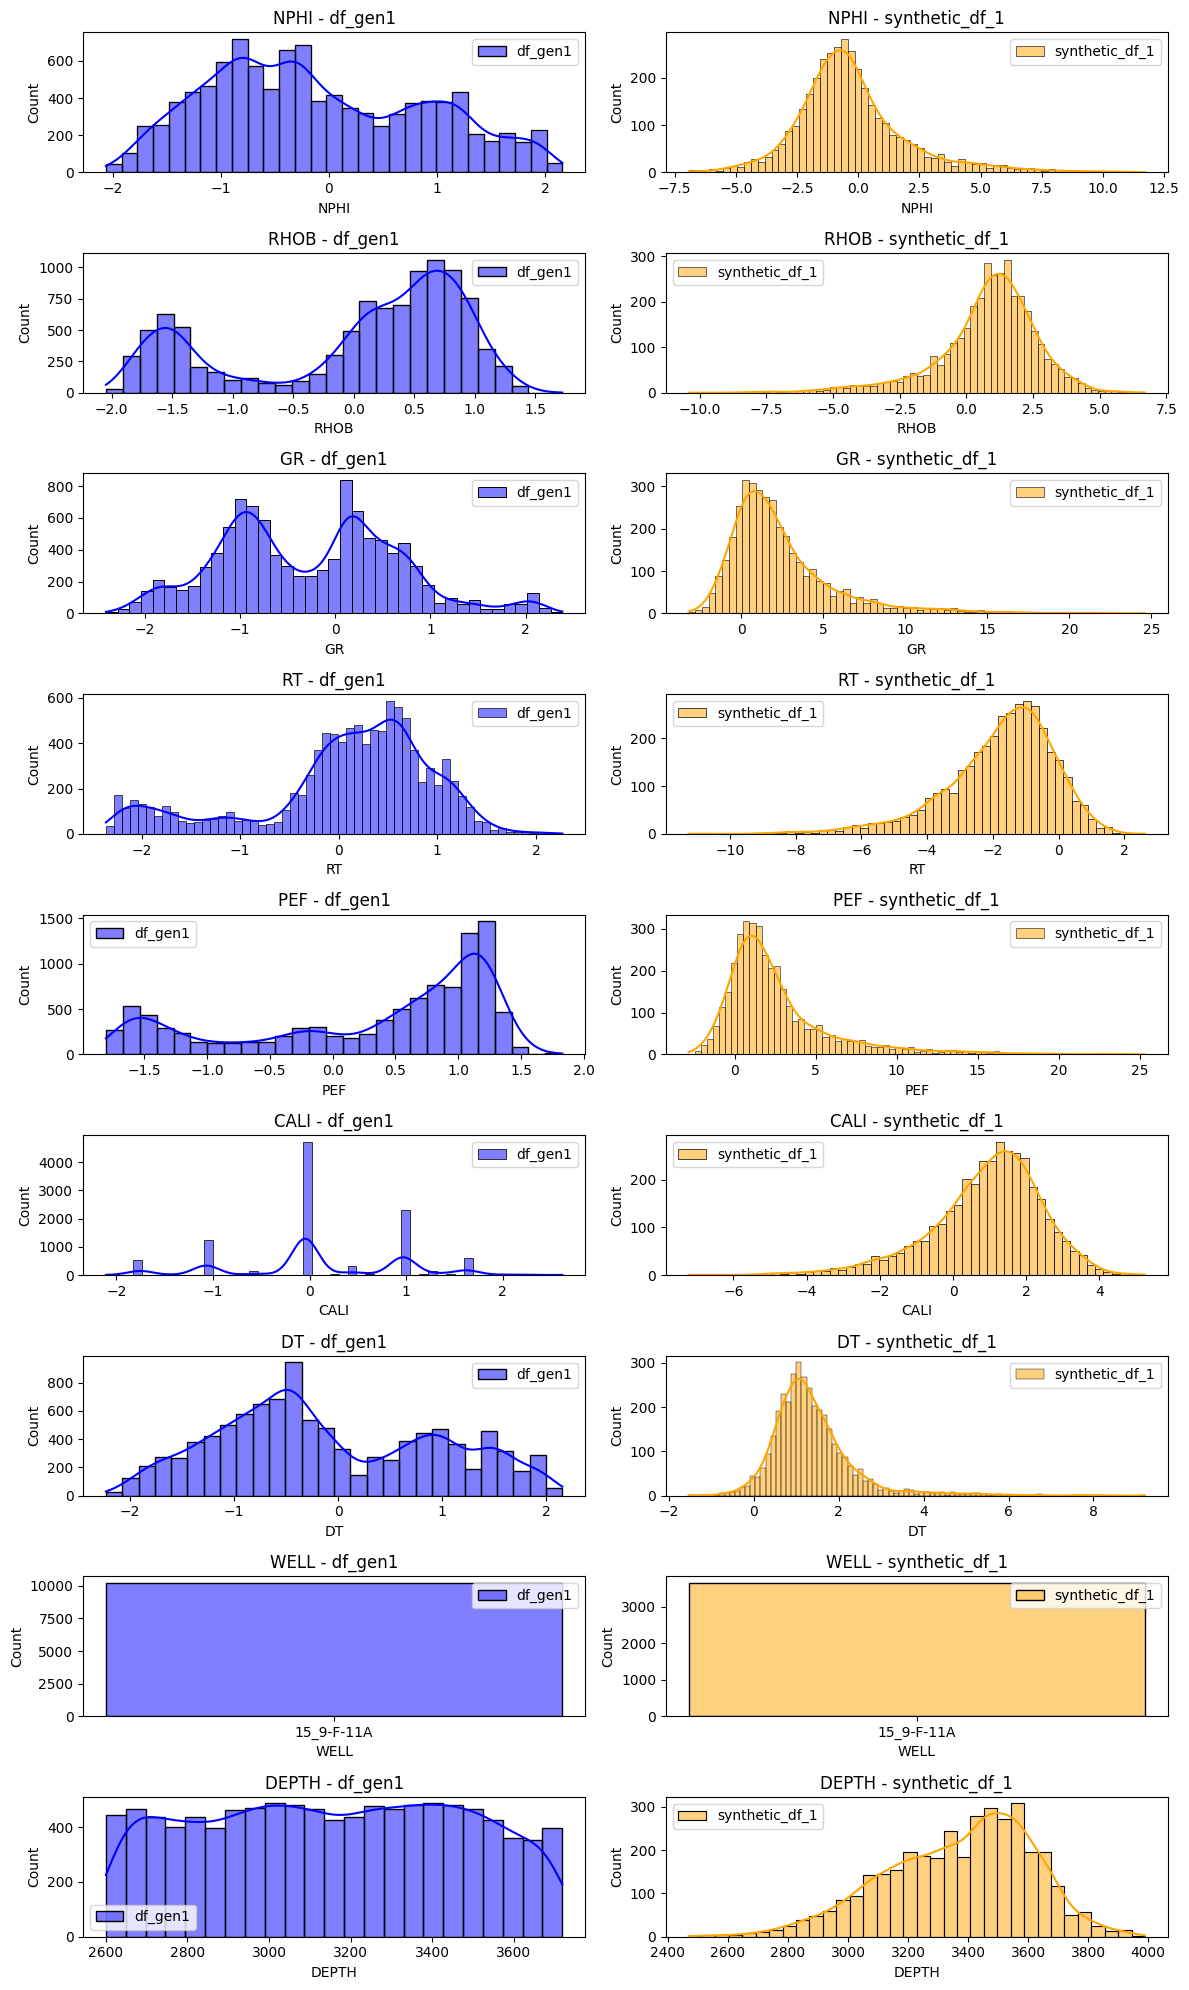

In [54]:
fig, axes = plt.subplots(nrows=len(df_gen1.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_1
for i, column in enumerate(df_gen1.columns):
    sns.histplot(df_gen1[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen1')
    axes[i, 0].set_title(f'{column} - df_gen1')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_1[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_1')
    axes[i, 1].set_title(f'{column} - synthetic_df_1')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

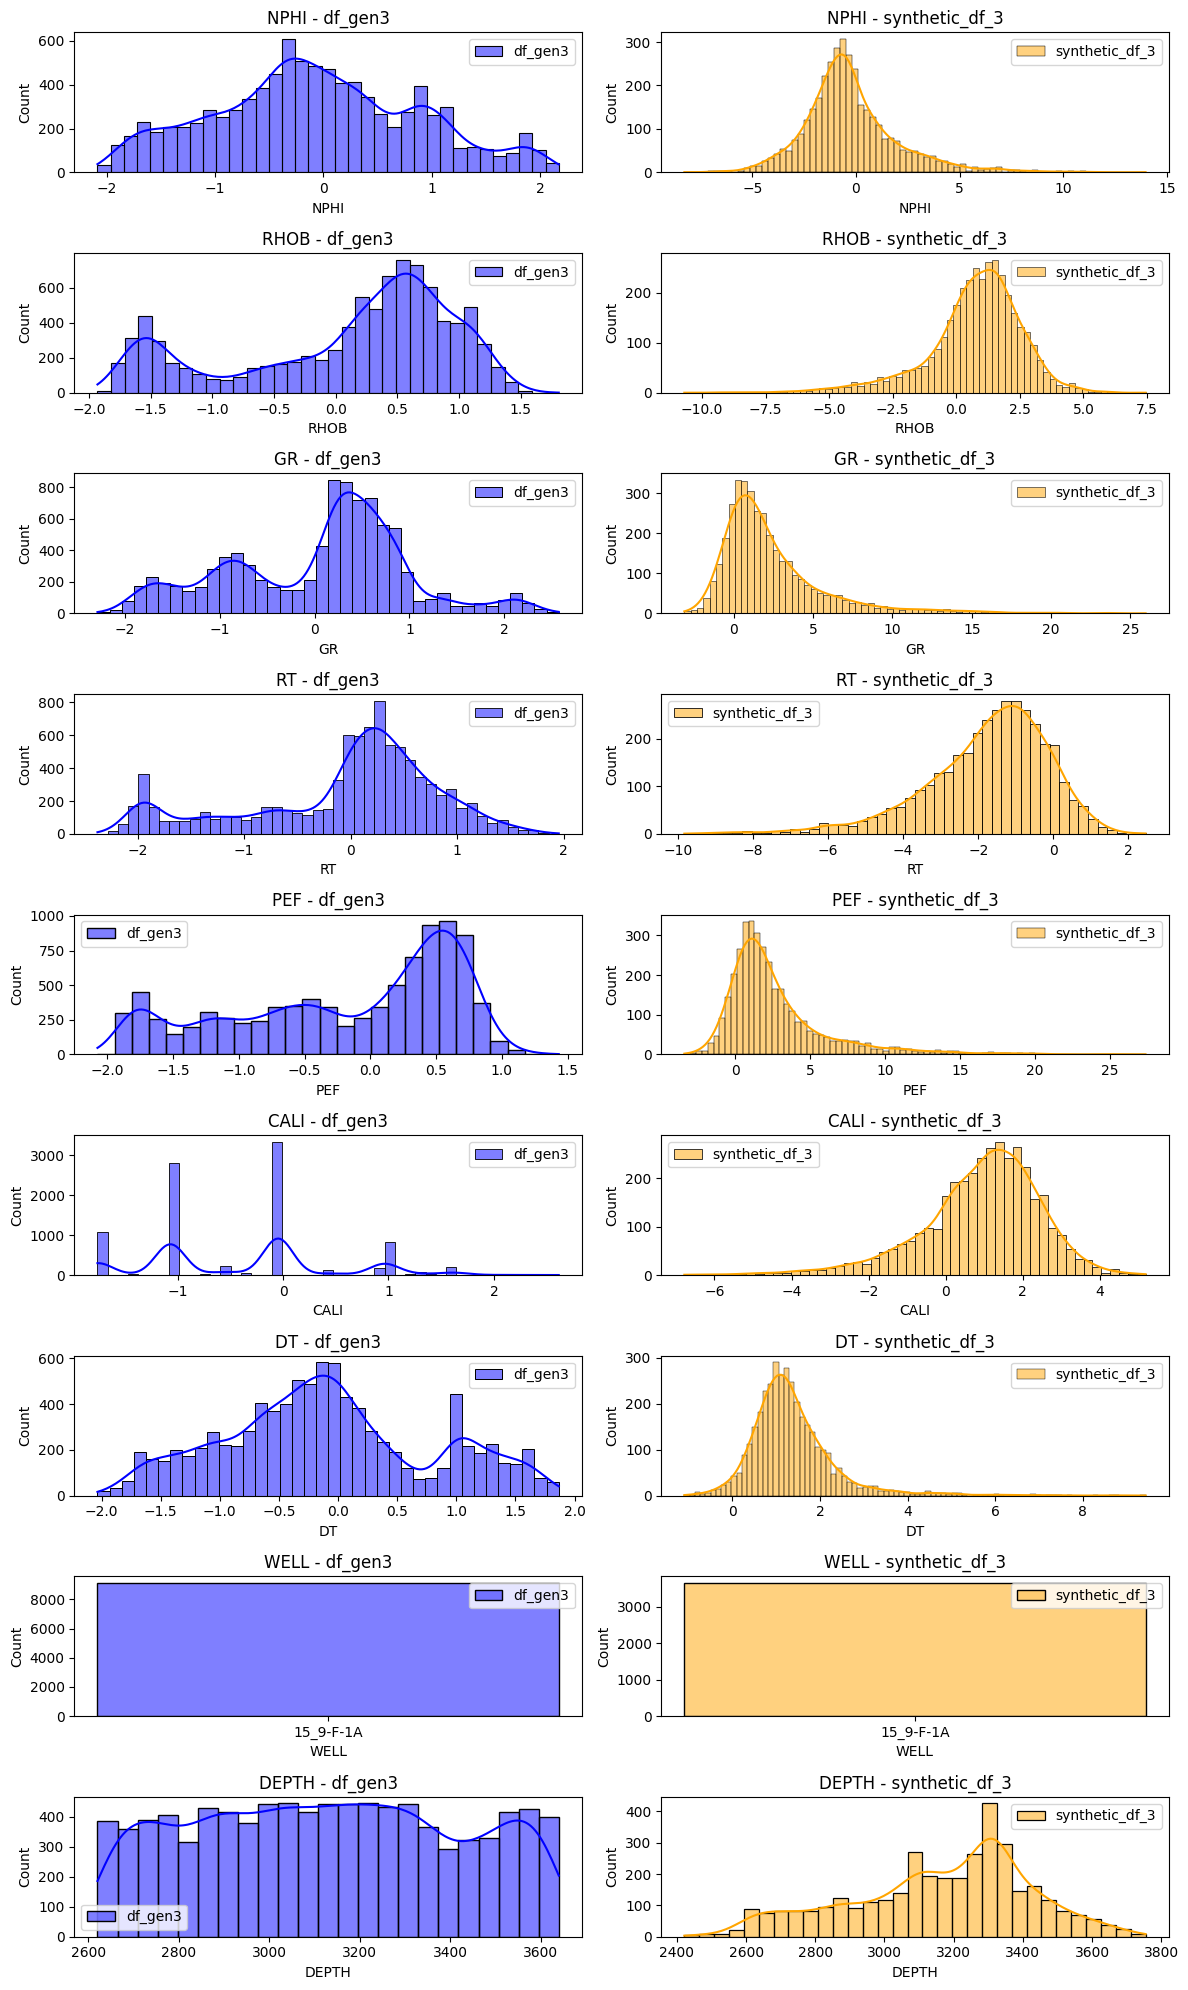

In [55]:
fig, axes = plt.subplots(nrows=len(df_gen3.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen3 and synthetic_df_3
for i, column in enumerate(df_gen3.columns):
    sns.histplot(df_gen3[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen3')
    axes[i, 0].set_title(f'{column} - df_gen3')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_3[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_3')
    axes[i, 1].set_title(f'{column} - synthetic_df_3')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

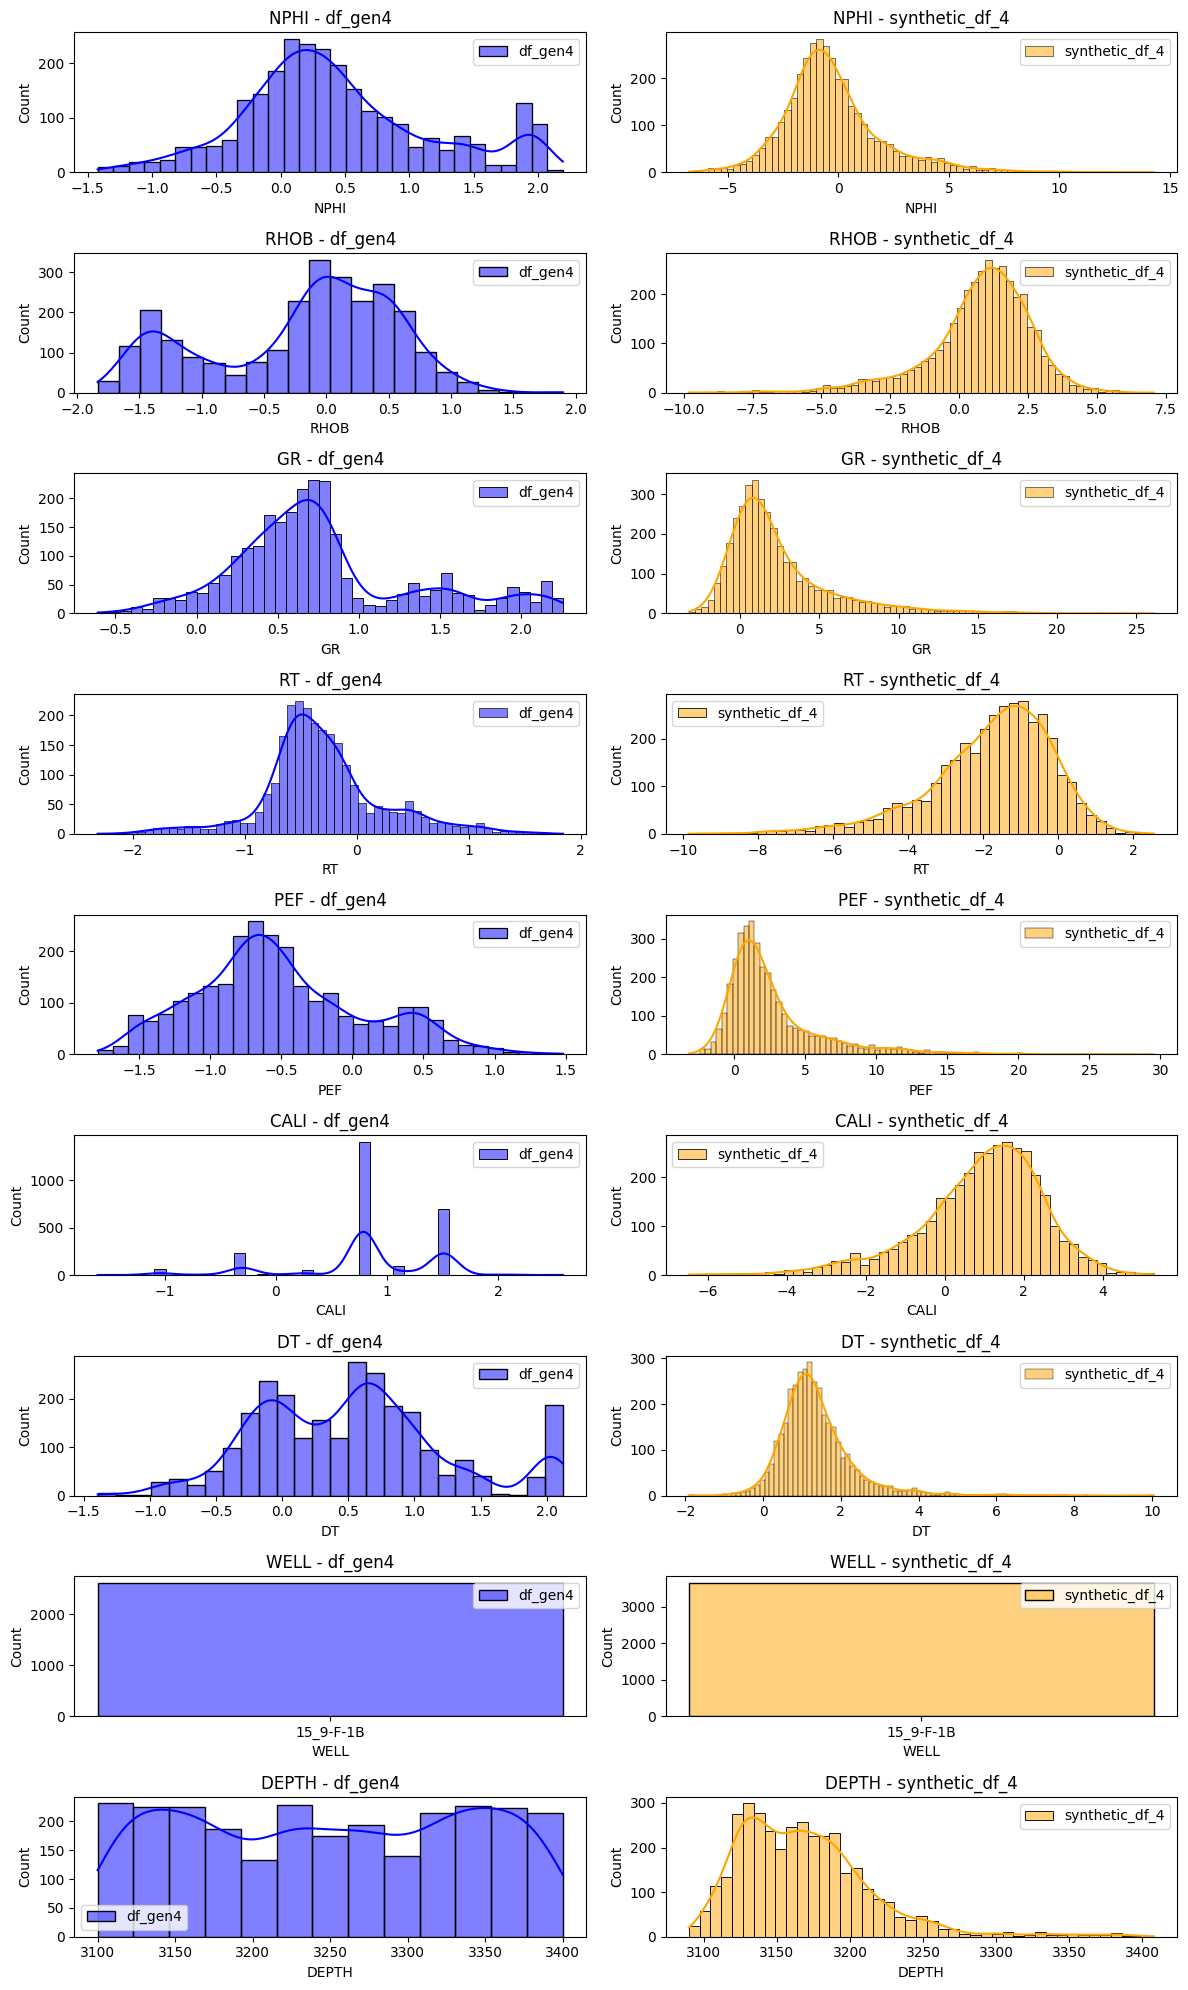

In [56]:
fig, axes = plt.subplots(nrows=len(df_gen4.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_4
for i, column in enumerate(df_gen4.columns):
    sns.histplot(df_gen4[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen4')
    axes[i, 0].set_title(f'{column} - df_gen4')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_4[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_4')
    axes[i, 1].set_title(f'{column} - synthetic_df_4')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [57]:
df_gen1 = pd.concat([df_gen1, synthetic_df_1])
df_gen1 = df_gen1.sort_values(by='DEPTH')

df_gen3 = pd.concat([df_gen1, synthetic_df_3])
df_gen3  = df_gen3.sort_values(by='DEPTH')

df_gen4 = pd.concat([df_gen1, synthetic_df_4])
df_gen4 = df_gen4.sort_values(by='DEPTH')


In [58]:
X_train_new = pd.concat([df_gen1, df_gen3, df_gen4])
y_train_new = X_train_new['DT']
X_train_new.drop(['DT', 'WELL', 'DEPTH'], axis = 1, inplace= True)

y_train_new = y_train_new.values.reshape(-1,1).astype('float32')
X_train_new = X_train_new.values.astype('float32')

### Decison Tree Regressor


In [59]:
# Decision Tree Regressor object
model_decision_tree = DecisionTreeRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the regressor to the training fold
    model_decision_tree.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = model_decision_tree.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_decision_tree = model_decision_tree.predict(X_val1)
print("R2 Log 1: {}".format(round(model_decision_tree.score(X_val1, y_val1), 4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_decision_tree))
print("RMSE Log 1: {}".format(round(rmse, 4)))

# Validation: Predict on well 3
y_pred3_decision_tree = model_decision_tree.predict(X_val3)
print("R2 Log 3: {}".format(round(model_decision_tree.score(X_val3, y_val3), 4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_decision_tree))
print("RMSE Log 3: {}".format(round(rmse, 4)))

# Validation: Predict on well 4
y_pred4_decision_tree = model_decision_tree.predict(X_val4)
print("R2 Log 4: {}".format(round(model_decision_tree.score(X_val4, y_val4), 4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_decision_tree))
print("RMSE Log 4: {}".format(round(rmse, 4)))


RMSE for Fold 1: 0.2177
RMSE for Fold 2: 0.2133
RMSE for Fold 3: 0.2312
RMSE for Fold 4: 0.2128
RMSE for Fold 5: 0.2117
Average RMSE: 0.2173
R2 Log 1: 0.9751
RMSE Log 1: 0.1695
R2 Log 3: 0.9692
RMSE Log 3: 0.1623
R2 Log 4: 0.9445
RMSE Log 4: 0.1796


### Gradient Booster Regressor

In [60]:
# Gradient Booster object
model_grad_boost = GradientBoostingRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the regressor to the training fold
    model_grad_boost.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = model_grad_boost.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_grad_boost = model_grad_boost.predict(X_val1)
print("R2 Log 1: {}".format(round(model_grad_boost.score(X_val1, y_val1),4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_grad_boost))
print("RMSE Log 1: {}".format(round(rmse,4)))

# Validation: Predict on well 3
y_pred3_grad_boost = model_grad_boost.predict(X_val3)
print("R2 Log 3: {}".format(round(model_grad_boost.score(X_val3, y_val3),4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_grad_boost))
print("RMSE Log 3: {}".format(round(rmse,4)))

# Validation: Predict on well 4
y_pred4_grad_boost = model_grad_boost.predict(X_val4)
print("R2 Log 4: {}".format(round(model_grad_boost.score(X_val4, y_val4),4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_grad_boost))
print("RMSE Log 4: {}".format(round(rmse,4)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 1: 0.2015


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 2: 0.2048


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 3: 0.2115


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 4: 0.1952


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 5: 0.2092
Average RMSE: 0.2044
R2 Log 1: 0.9526
RMSE Log 1: 0.2339
R2 Log 3: 0.9413
RMSE Log 3: 0.224
R2 Log 4: 0.9012
RMSE Log 4: 0.2395


### Neural Network

In [61]:
# Define the neural network model
def neural_network_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer
    ])
    return model

# Initialize and compile the neural network model
model_nn = neural_network_model(X_train_new.shape[1:])
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Initialize KFold with number of splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the neural network model to the training fold
    history_nn = model_nn.fit(X_train_fold, y_train_fold, epochs=16, batch_size=1024, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Predict on the validation fold
    y_pred_fold = model_nn.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_nn = model_nn.predict(X_val1)
rmse_nn1 = np.sqrt(mean_squared_error(y_val1, y_pred1_nn))
print("RMSE Neural Network Log 1: {}".format(round(rmse_nn1, 4)))

# Validation: Predict on well 3
y_pred3_nn = model_nn.predict(X_val3)
rmse_nn3 = np.sqrt(mean_squared_error(y_val3, y_pred3_nn))
print("RMSE Neural Network Log 3: {}".format(round(rmse_nn3, 4)))

# Validation: Predict on well 4
y_pred4_nn = model_nn.predict(X_val4)
rmse_nn4 = np.sqrt(mean_squared_error(y_val4, y_pred4_nn))
print("RMSE Neural Network Log 4: {}".format(round(rmse_nn4, 4)))


138/138 [==============================] - 0s 2ms/step
RMSE for Fold 1: 0.1971
138/138 [==============================] - 0s 2ms/step
RMSE for Fold 2: 0.1945
138/138 [==============================] - 0s 2ms/step
RMSE for Fold 3: 0.1959
138/138 [==============================] - 0s 2ms/step
RMSE for Fold 4: 0.1792
138/138 [==============================] - 0s 2ms/step
RMSE for Fold 5: 0.1846
Average RMSE: 0.1903
351/351 [==============================] - 1s 2ms/step
RMSE Neural Network Log 1: 0.260699987411499
319/319 [==============================] - 1s 2ms/step
RMSE Neural Network Log 3: 0.22450000047683716
94/94 [==============================] - 0s 2ms/step
RMSE Neural Network Log 4: 0.25099998712539673


### LSTM

In [62]:
# Preparing data for LSTM
time_steps = 10

def prep_for_lstm(X_in, y_in, time_steps = 10):
    X_lstm = []
    y_lstm = []
    for i in range(len(X_in) - time_steps):
        X_lstm.append(X_in[i:i+time_steps])
        y_lstm.append(y_in[i+time_steps])

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    return X_lstm, y_lstm

X_train_lstm, y_train_lstm = prep_for_lstm(X_train_new, y_train_new, time_steps = time_steps)
X_val1_lstm, y_val1_lstm = prep_for_lstm(X_val1, y_val1, time_steps = time_steps)
X_val3_lstm, y_val3_lstm = prep_for_lstm(X_val3, y_val3, time_steps = time_steps)
X_val4_lstm, y_val4_lstm = prep_for_lstm(X_val4, y_val4, time_steps = time_steps)


In [63]:
y_train_lstm.shape

(48974, 1)

In [64]:
# Define bidirectional LSTM model with three layers
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(units=64)))
model_lstm.add(Dense(units=1))  # Output layer
model_lstm.compile(optimizer=Adam(), loss='mean_squared_error')

# Initialize KFold with number of splits
kf = KFold(n_splits=5)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train_lstm)):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[val_index]
    y_train_fold, y_val_fold = y_train_lstm[train_index], y_train_lstm[val_index]


    # Fit the bidirectional LSTM model to the training fold
    history = model_lstm.fit(X_train_fold, y_train_fold, epochs=16, batch_size=1024, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Predict on the validation fold
    y_pred_fold = model_lstm.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_lstm = model_lstm.predict(X_val1_lstm)
rmse_lstm1 = np.sqrt(mean_squared_error(y_val1_lstm, y_pred1_lstm))
print("RMSE LSTM Log 1: {}".format(round(rmse_lstm1, 4)))

# Validation: Predict on well 3
y_pred3_lstm = model_lstm.predict(X_val3_lstm)
rmse_lstm3 = np.sqrt(mean_squared_error(y_val3_lstm, y_pred3_lstm))
print("RMSE LSTM Log 3: {}".format(round(rmse_lstm3, 4)))

# Validation: Predict on well 4
y_pred4_lstm = model_lstm.predict(X_val4_lstm)
rmse_lstm4 = np.sqrt(mean_squared_error(y_val4_lstm, y_pred4_lstm))
print("RMSE LSTM Log 4: {}".format(round(rmse_lstm4, 4)))


307/307 [==============================] - 3s 6ms/step
RMSE for Fold 1: 1.0174
307/307 [==============================] - 2s 7ms/step
RMSE for Fold 2: 0.7851
307/307 [==============================] - 2s 7ms/step
RMSE for Fold 3: 1.2725
307/307 [==============================] - 2s 5ms/step
RMSE for Fold 4: 0.7438
307/307 [==============================] - 1s 5ms/step
RMSE for Fold 5: 0.5819
Average RMSE: 0.8801
350/350 [==============================] - 2s 5ms/step
RMSE LSTM Log 1: 0.9178000092506409
319/319 [==============================] - 2s 5ms/step
RMSE LSTM Log 3: 0.7114999890327454
94/94 [==============================] - 0s 5ms/step
RMSE LSTM Log 4: 0.5331000089645386


### Formatting back the predictions

In [65]:
# Make the transformer fit to the target
y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform  y_val, y_pred
y_val1 = scaler.inverse_transform(y_val1.reshape(-1,1))
y_val3 = scaler.inverse_transform(y_val3.reshape(-1,1))
y_val4 = scaler.inverse_transform(y_val4.reshape(-1,1))


# Define a list to hold all predictions
all_predictions = [y_pred1_grad_boost, y_pred3_grad_boost, y_pred4_grad_boost,
                   y_pred1_nn, y_pred3_nn, y_pred4_nn,
                   y_pred1_lstm, y_pred3_lstm, y_pred4_lstm,
                   y_pred1_decision_tree, y_pred3_decision_tree, y_pred4_decision_tree
                   ]

# Inverse transform all predictions
all_predictions_inverse = [scaler.inverse_transform(pred.reshape(-1, 1)) for pred in all_predictions]

# Split the transformed predictions back into separate variables
(
    y_pred1_grad_boost_inv,  y_pred3_grad_boost_inv, y_pred4_grad_boost_inv,
    y_pred1_nn_inv, y_pred3_nn_inv, y_pred4_nn_inv,
    y_pred1_lstm_inv, y_pred3_lstm_inv, y_pred4_lstm_inv,
    y_pred1_decision_tree_inv, y_pred3_decision_tree_inv, y_pred4_decision_tree_inv
) = all_predictions_inverse

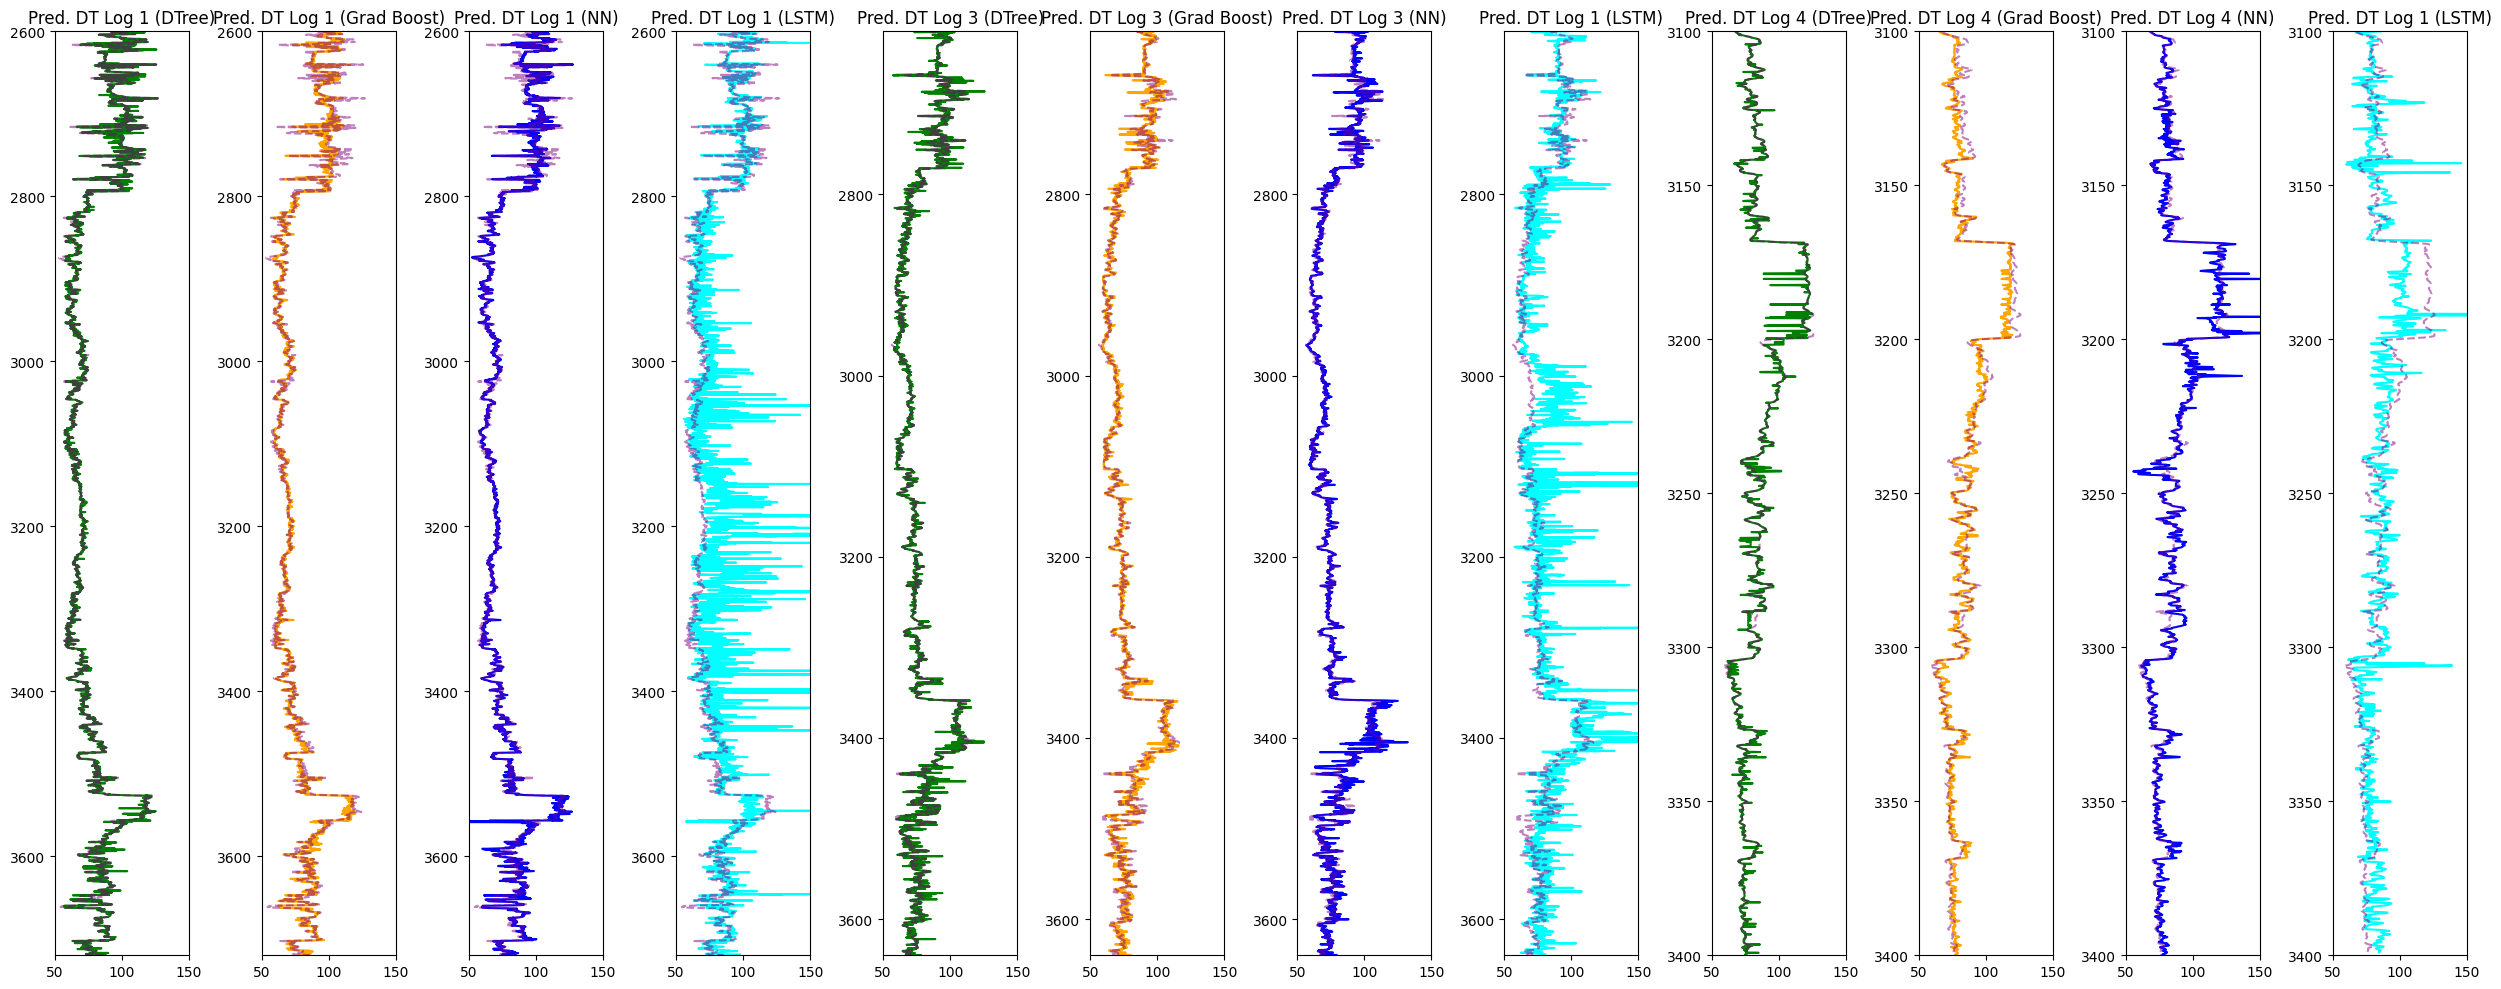

In [66]:
x_plott = [y_pred1_decision_tree_inv, y_pred1_grad_boost_inv, y_pred1_nn_inv,  y_pred1_lstm_inv,
           y_pred3_decision_tree_inv, y_pred3_grad_boost_inv, y_pred3_nn_inv,  y_pred3_lstm_inv,
           y_pred4_decision_tree_inv, y_pred4_grad_boost_inv, y_pred4_nn_inv,  y_pred4_lstm_inv]

x_real_plott = [
    y_val1,
    y_val3,
    y_val4
]

x_real_plott_lstm = [
    y_val1_lstm,
    y_val3_lstm,
    y_val4_lstm
]

y_plott = [log1['DEPTH'],
           log3['DEPTH'],
           log4['DEPTH']]

color_preds = ['green', 'orange', 'blue', 'cyan'] * 3
title_preds = ['Pred. DT Log 1 (DTree)', 'Pred. DT Log 1 (Grad Boost)', 'Pred. DT Log 1 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 3 (DTree)', 'Pred. DT Log 3 (Grad Boost)', 'Pred. DT Log 3 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 4 (DTree)', 'Pred. DT Log 4 (Grad Boost)', 'Pred. DT Log 4 (NN)',  'Pred. DT Log 1 (LSTM)',]

fig, ax = plt.subplots(nrows=1, ncols=12, figsize=(25, 10))

for i, (x_pred, title) in enumerate(zip(x_plott, title_preds)):
    # Reshape y[i] to match the shape of x_pred
    y_i_reshaped = y_plott[i//4]
    ax[i].plot(x_pred, y_i_reshaped[:len(x_pred)], color=color_preds[i])
    ax[i].plot(x_real_plott[i//4], y_i_reshaped, color='purple', linestyle='dashed', alpha = 0.5) #if i%4 != 0 else x_real_plott_lstm[i//4]
    ax[i].set_xlim(50, 150)
    ax[i].set_ylim(max(y_i_reshaped), min(y_i_reshaped))  # Ensure correct order of y-axis
    ax[i].set_title(title)

plt.tight_layout()
plt.show()


In [67]:
# Define the test data
names_test = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []

for i in range(len(names_test)):
  # split the df with respect to its name
  test = pred.loc[pred['WELL'] == names_test[i]]

  # Drop well name column
  test = test.drop(['WELL'], axis=1)

  # Define X_test (feature)
  X_test_ = test[feature_names].values

  # Define depth
  depth_ = test['DEPTH'].values

  X_test.append(X_test_)
  depths.append(depth_)

# For each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [68]:
X_test2

array([[ 0.075,  2.605,  9.348,  8.331,  7.451,  8.547],
       [ 0.077,  2.602,  9.362,  8.289,  7.464,  8.547],
       [ 0.078,  2.599,  9.545,  8.247,  7.405,  8.547],
       ...,
       [ 0.103,  2.592, 32.217,  4.232,  4.729,  8.734],
       [ 0.108,  2.583, 29.841,  4.233,  4.705,  8.75 ],
       [ 0.114,  2.571, 31.423,  4.225,  4.617,  8.76 ]])

In [69]:
# Transform X_test of log 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

X_test2_lstm, _ = prep_for_lstm(X_test2, X_test2, time_steps = time_steps)
X_test5_lstm, _ = prep_for_lstm(X_test5, X_test5, time_steps = time_steps)


# Predictions for log 2 using all models
y_pred2_grad_boost = model_grad_boost.predict(X_test2)
y_pred2_decision_tree = model_decision_tree.predict(X_test2)
y_pred2_nn = model_nn.predict(X_test2)
y_pred2_lstm = model_lstm.predict(X_test2_lstm)
#y_pred2_transformer = model_transformer.predict(X_test2)

# Predictions for log 5 using all models
y_pred5_grad_boost = model_grad_boost.predict(X_test5)
y_pred5_decision_tree = model_decision_tree.predict(X_test5)
y_pred5_nn = model_nn.predict(X_test5)
y_pred5_lstm = model_lstm.predict(X_test5_lstm)
#y_pred5_transformer = model_transformer.predict(X_test5)

y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform y_pred for log 2
y_pred2_grad_boost = scaler.inverse_transform(y_pred2_grad_boost.reshape(-1,1))
y_pred2_decision_tree = scaler.inverse_transform(y_pred2_decision_tree.reshape(-1,1))
y_pred2_nn = scaler.inverse_transform(y_pred2_nn.reshape(-1,1))
y_pred2_lstm = scaler.inverse_transform(y_pred2_lstm.reshape(-1,1))
#y_pred2_transformer = scaler.inverse_transform(y_pred2_transformer.reshape(-1,1))

# Inverse transform y_pred for log 5
y_pred5_grad_boost = scaler.inverse_transform(y_pred5_grad_boost.reshape(-1,1))
y_pred5_decision_tree = scaler.inverse_transform(y_pred5_decision_tree.reshape(-1,1))
y_pred5_nn = scaler.inverse_transform(y_pred5_nn.reshape(-1,1))
y_pred5_lstm = scaler.inverse_transform(y_pred5_lstm.reshape(-1,1))
#y_pred5_transformer = scaler.inverse_transform(y_pred5_transformer.reshape(-1,1))


297/297 [==============================] - 1s 5ms/step


In [70]:
def pad_predicted_values(predicted_values, target_column, window_size=10):
    """
    Pad the predicted values using a moving average to fill in the gaps.

    Parameters:
        predicted_values (np.ndarray): The predicted values to pad.
        target_column (pd.Series): The target column used to calculate moving average.
        window_size (int): The size of the moving average window.

    Returns:
        np.ndarray: The padded predicted values.
    """
    # Calculate the number of values to pad
    pad_length = len(target_column) - len(predicted_values)

    # Pad the predicted values with NaNs to match the length of target_column
    padding = np.full((pad_length, 1), np.nan)

    padded_values = np.concatenate((padding, predicted_values))

    for i in range(len(padded_values)-1, -1, -1):
        if np.isnan(padded_values[i][0]):
            padded_values[i][0] = np.mean(padded_values[i+1:i+1+window_size])



    return padded_values


In [71]:
y_pred2_lstm

array([[62.52192 ],
       [61.84211 ],
       [59.922825],
       ...,
       [80.2589  ],
       [93.37684 ],
       [91.83078 ]], dtype=float32)

In [72]:
pad_predicted_values(y_pred2_lstm, y_pred2_nn)

array([[60.01539099],
       [60.18145633],
       [60.15794438],
       ...,
       [80.2589035 ],
       [93.37683868],
       [91.83078003]])

In [73]:
# Add predictions for log 2 to the dataframes
log2['DT_grad_boost'] = y_pred2_grad_boost
log2['DT_Tree'] = y_pred2_decision_tree
log2['DT_nn'] = y_pred2_nn
log2['DT_lstm'] = pad_predicted_values(y_pred2_lstm, log2['DT_Tree'])


# Add predictions for log 5 to the dataframes
log5['DT_grad_boost'] = y_pred5_grad_boost
log5['DT_Tree'] = y_pred5_decision_tree
log5['DT_nn'] = y_pred5_nn
log5['DT_lstm'] = pad_predicted_values(y_pred5_lstm, log5['DT_Tree'])
#log5['DT_transformer'] = y_pred5_transformer


<ipython-input-73-b0e2fc4a4f3b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_grad_boost'] = y_pred5_grad_boost
<ipython-input-73-b0e2fc4a4f3b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_Tree'] = y_pred5_decision_tree
<ipython-input-73-b0e2fc4a4f3b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

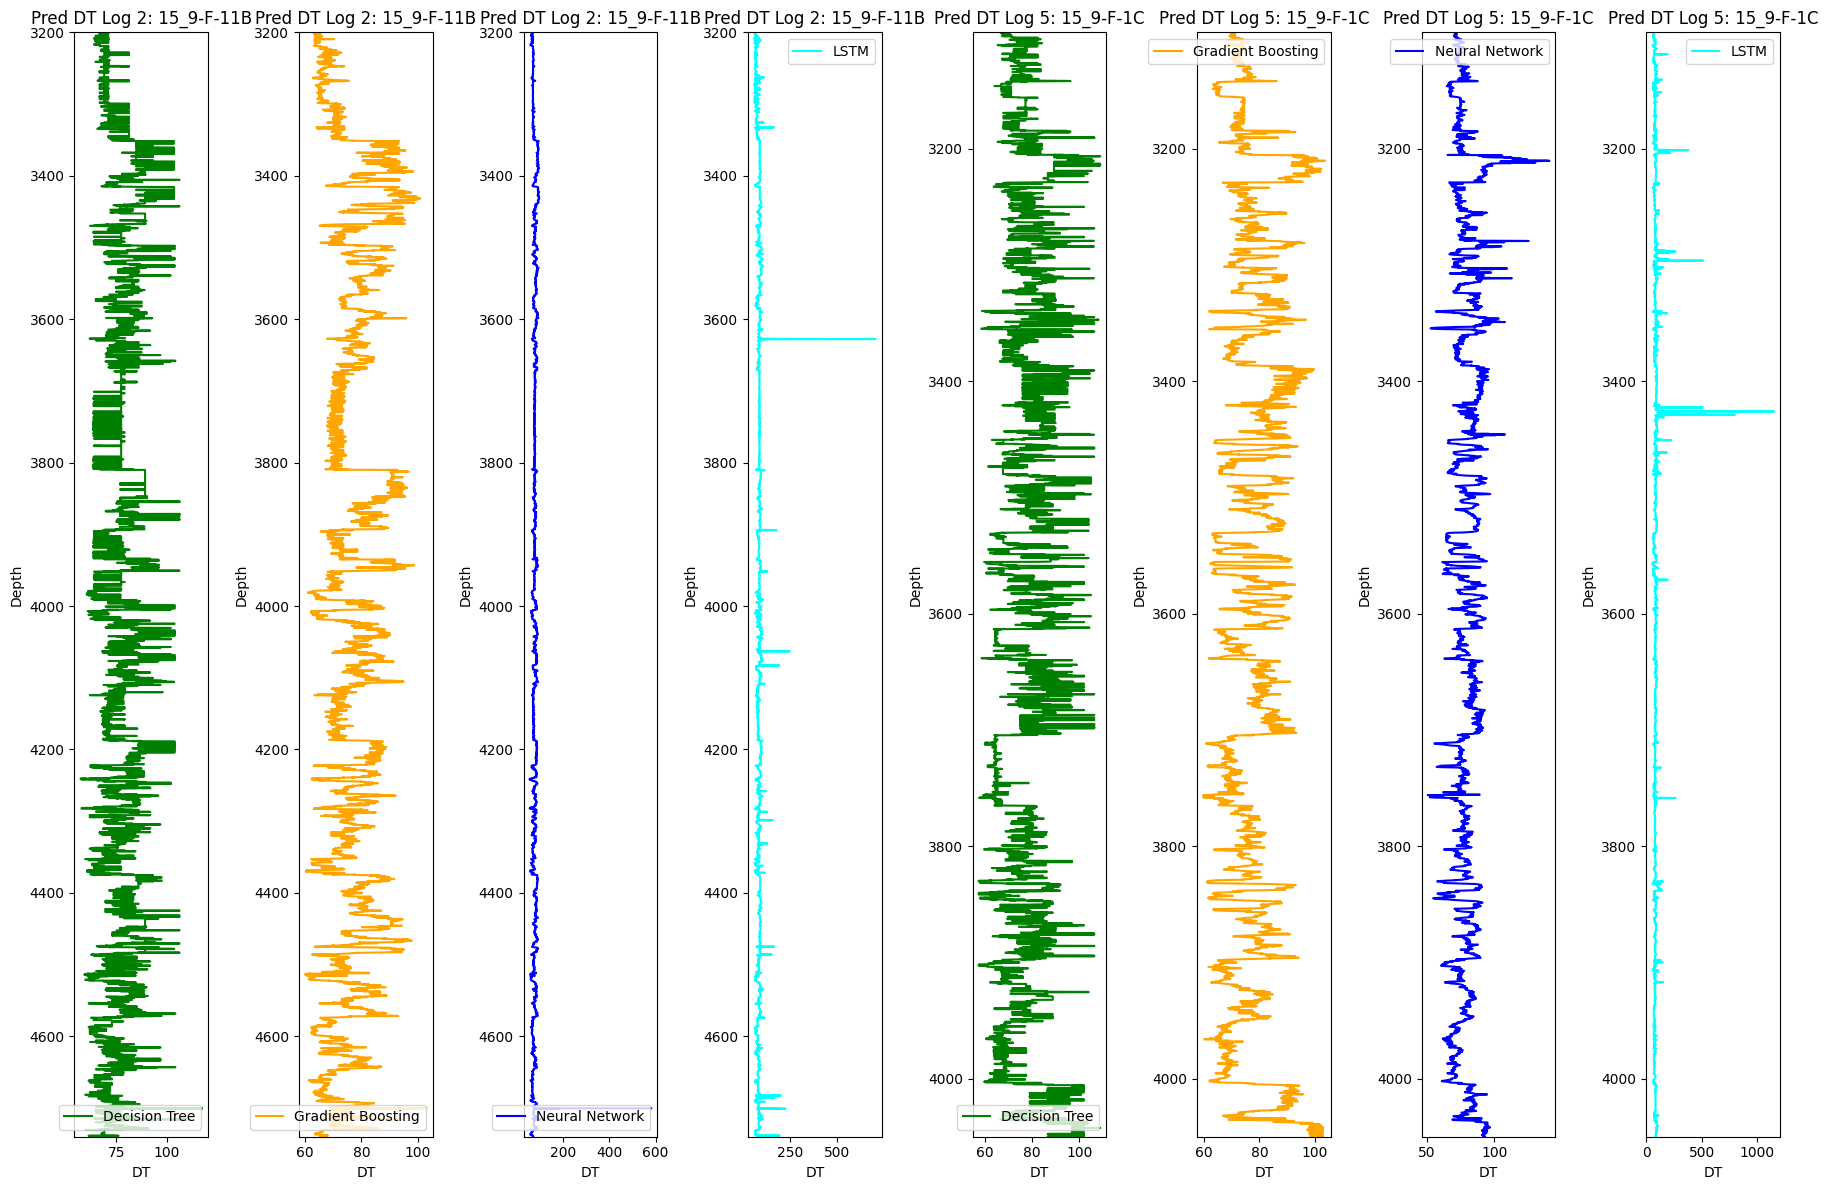

In [74]:
plt.figure(figsize=(18, 12))

# Plot predictions for log 2

plt.subplot(1, 8, 1)
plt.plot(y_pred2_decision_tree, depth2, color='green', label='Decision Tree')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 2)
plt.plot(y_pred2_grad_boost, depth2, color='orange', label='Gradient Boosting')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 3)
plt.plot(y_pred2_nn, depth2, color='blue', label='Neural Network')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 4)
plt.plot(pad_predicted_values(y_pred2_lstm, depth2), depth2, color='cyan', label='LSTM')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

# For log 5

plt.subplot(1, 8, 5)
plt.plot(y_pred5_decision_tree, depth5, color='green', label='Decision Tree')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 6)
plt.plot(y_pred5_grad_boost, depth5, color='orange', label='Gradient Boosting')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 7)
plt.plot(y_pred5_nn, depth5, color='blue', label='Neural Network')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 8)
plt.plot(pad_predicted_values(y_pred5_lstm, depth5), depth5, color='cyan', label='LSTM')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.tight_layout()
plt.show()


In [75]:
def makeplotpred(df, color_list, suptitle_str="Pass a suptitle"):
    # Column selection from df
    col_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT_Tree', 'DT_grad_boost', 'DT_nn', 'DT_lstm']
    # Plotting titles
    title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT Decsion Tree', 'Predicted DT GB', 'Predicted DT NN', 'Predicted DT LSTM']

    # Create the subplots; ncols equals the number of logs
    fig, ax = plt.subplots(nrows=1, ncols=len(col_names), figsize=(20,15))
    fig.suptitle(suptitle_str, size=20, y=1.05)

    # Looping each log to display in the subplots
    for i in range(len(col_names)):
        if i == 3:
            # for resistivity, semilog plot
            ax[i].semilogx(df[col_names[i]], df['DEPTH'], color=color_list[i])

        else:
            # for non-resistivity, normal plot
            ax[i].plot(df[col_names[i]], df['DEPTH'], color=color_list[i])

        ax[i].set_ylim(max(df['DEPTH']), min(df['DEPTH']))
        ax[i].set_title(title[i], pad=15)
        ax[i].grid(True)
        ax[i].legend()

    ax[2].set_xlim(0, 200)
    plt.tight_layout()
    plt.show()

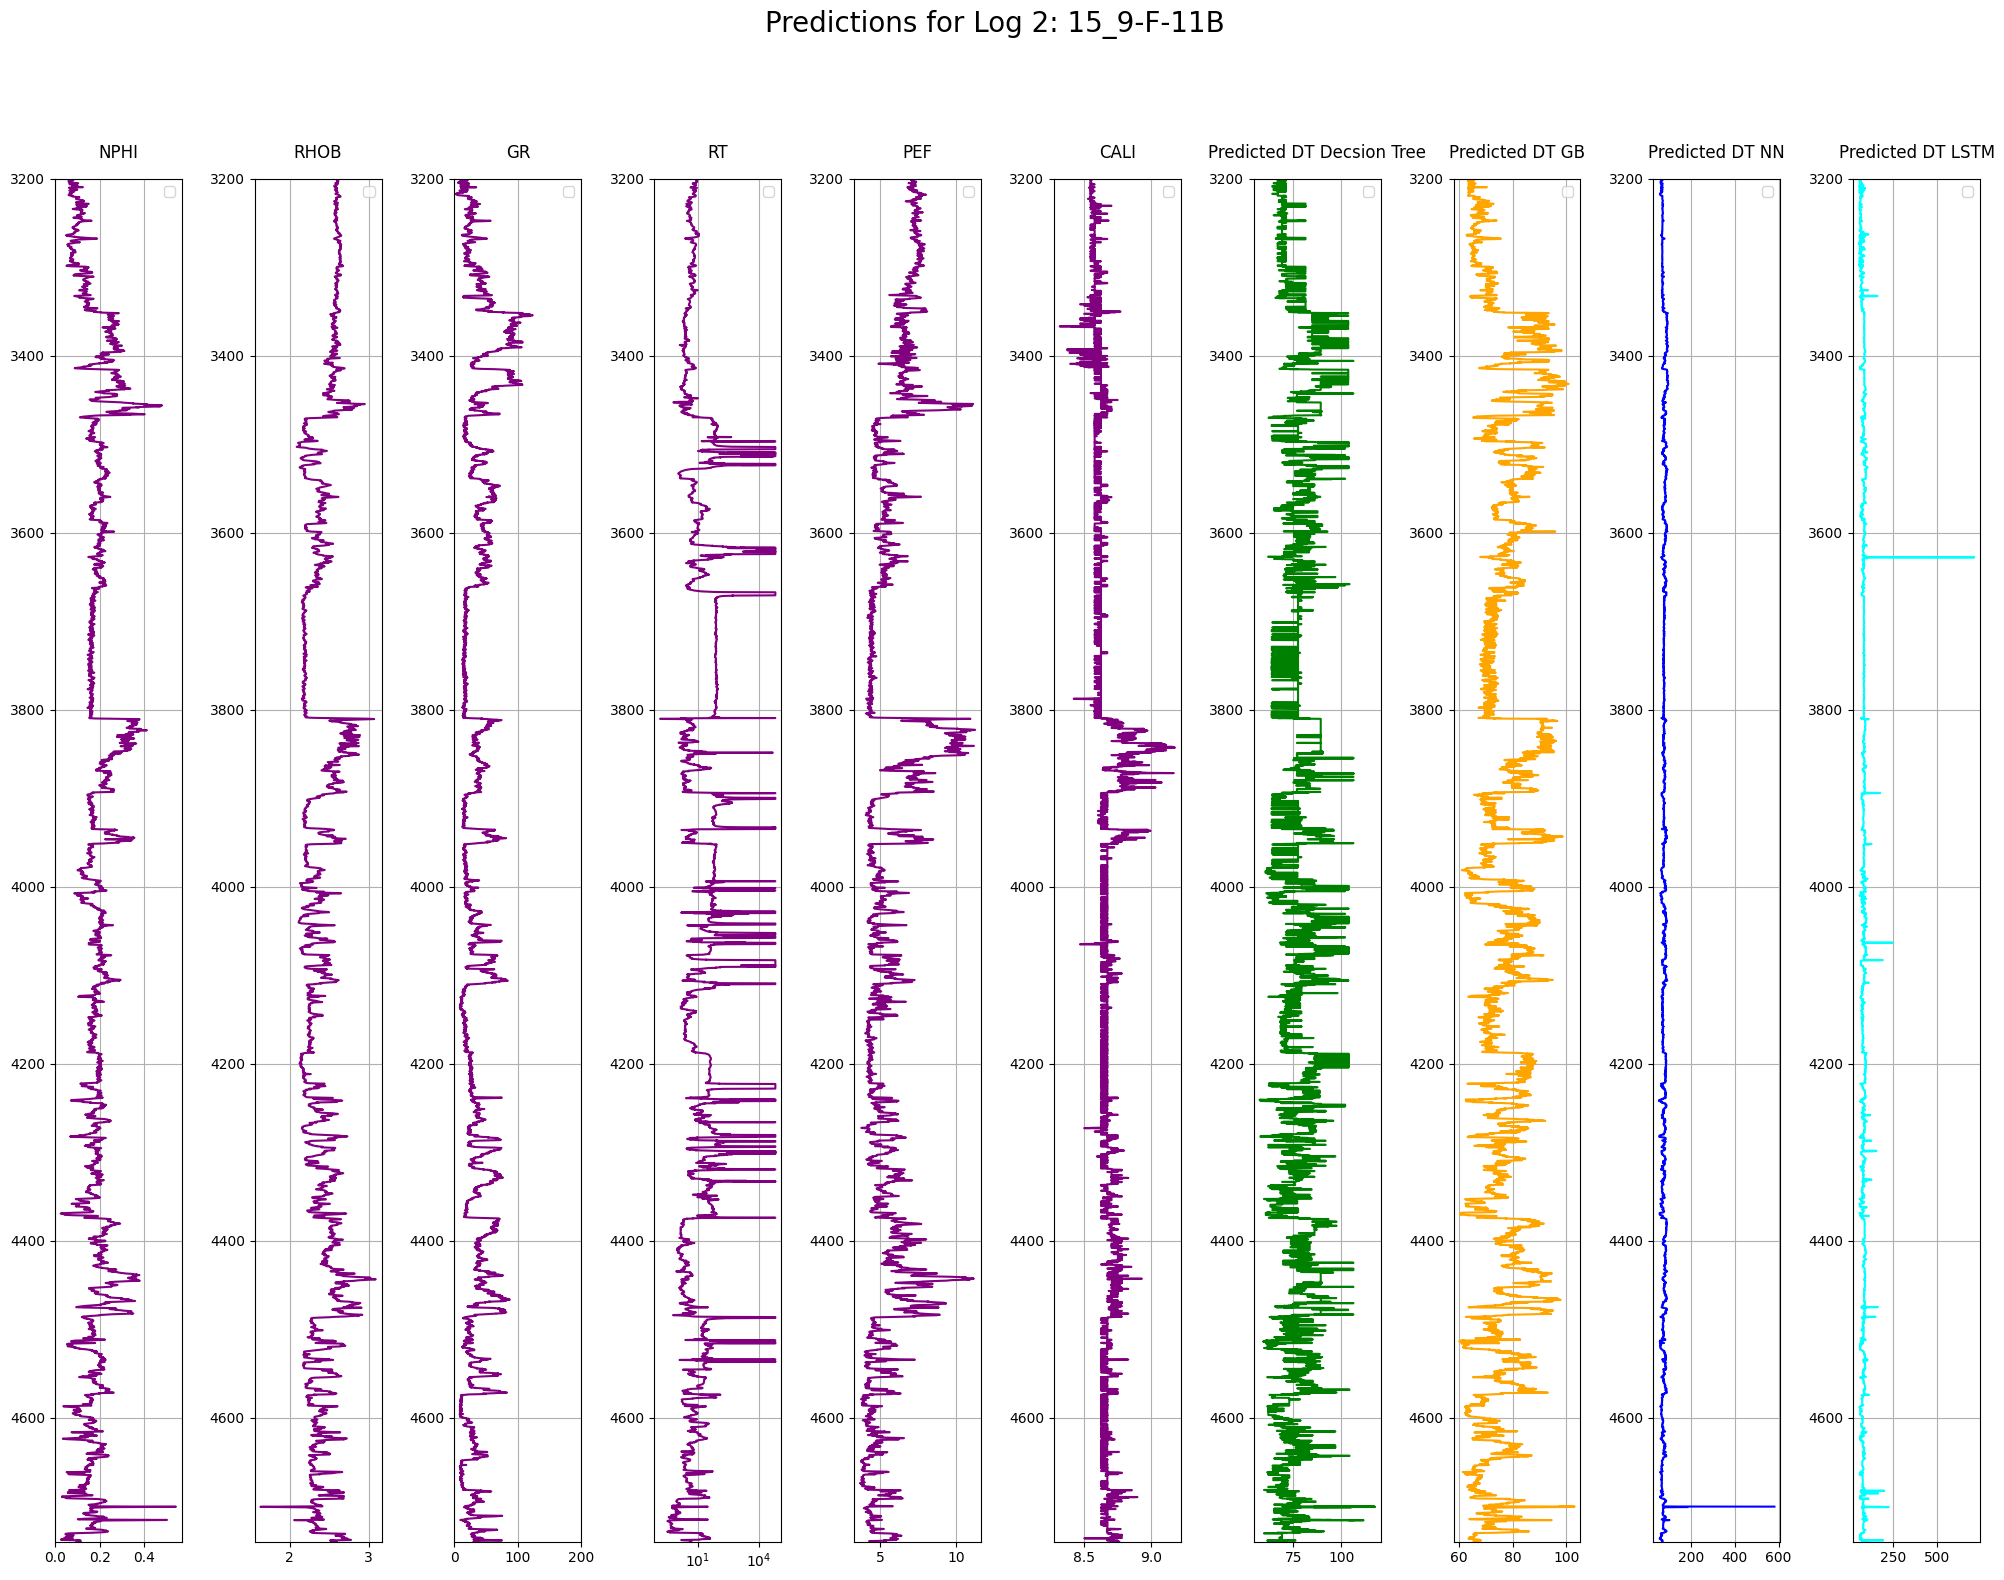

In [76]:
# Assuming `depth` is the depth information shared among all logs
makeplotpred(log2,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green', 'orange', 'blue', 'cyan'],
             suptitle_str="Predictions for Log 2: 15_9-F-11B")

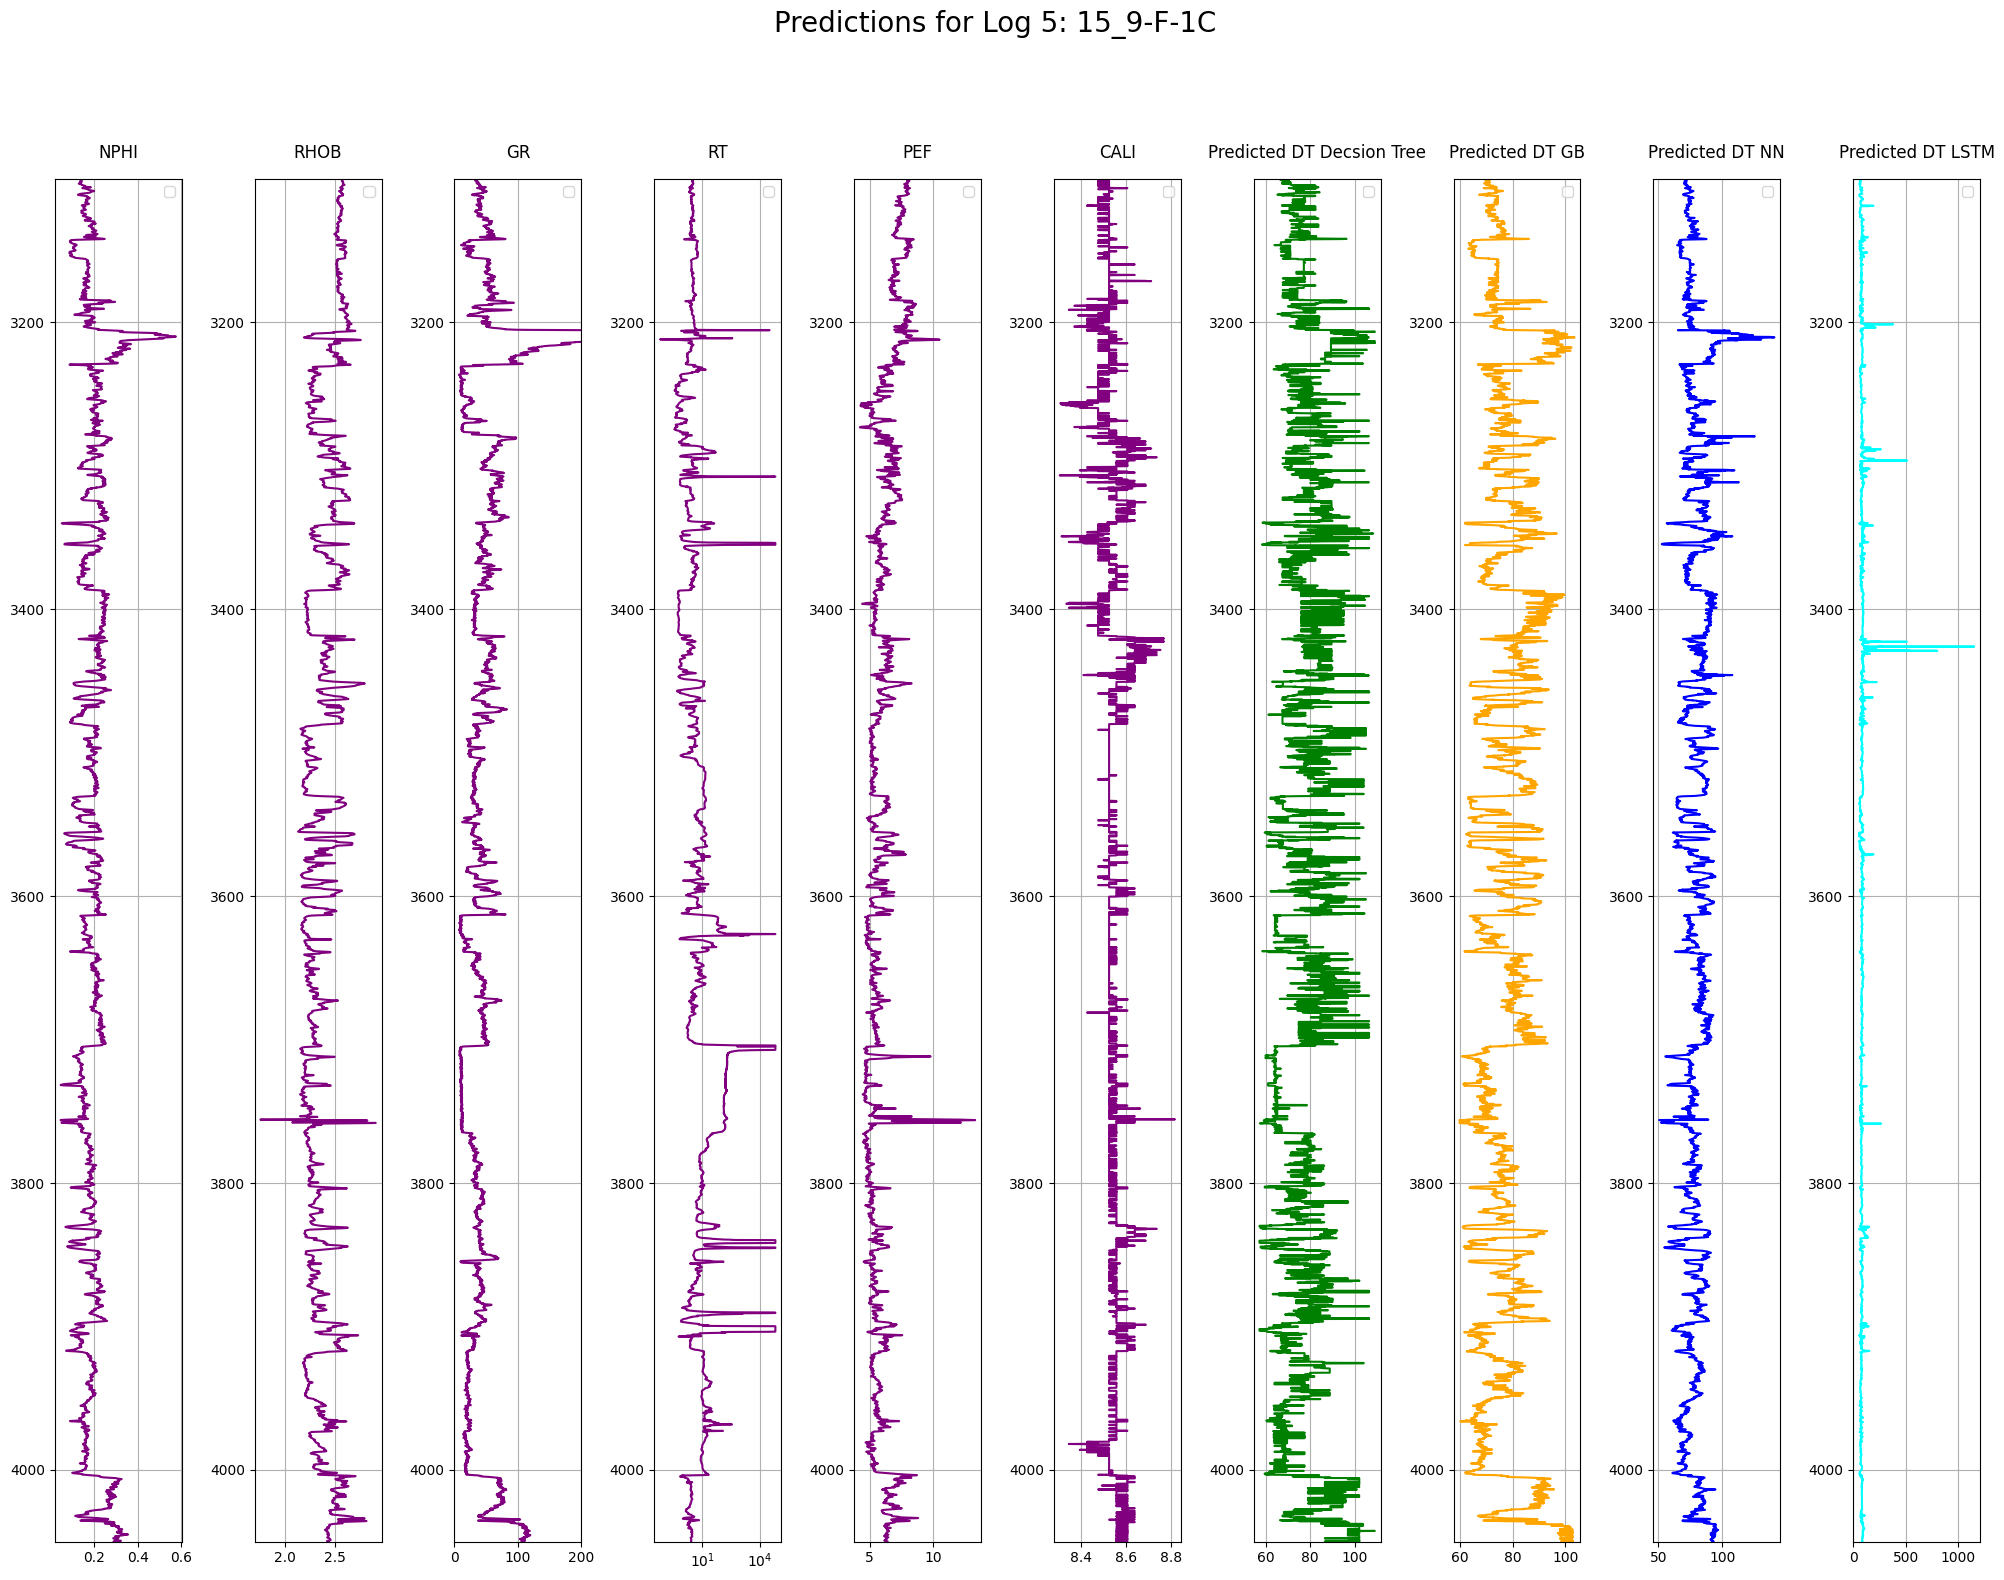

In [77]:
makeplotpred(log5,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green', 'orange', 'blue', 'cyan'],
             suptitle_str="Predictions for Log 5: 15_9-F-1C")